# **MODELO DE REGRESIÓN: Flight Prices by date**

Alumnas:
1. Leilani
2. Lucía
3. Natalia
4. Maria Jose
5. Maryam

### Dataset: [Flight Prices by date](https://www.kaggle.com/datasets/juhyounglee1127/flight-prices)

In [ ]:
# Importación de librerías necesarias

## Manejo de datos
import pandas as pd
import numpy as np
from datetime import datetime
import os

## Visualización
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split

## Modelado
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

## Evaluación de modelos
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, silhouette_score, calinski_harabasz_score
)

## Estadística y validación
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [ ]:
# Download latest version
import kagglehub

path = kagglehub.dataset_download("juhyounglee1127/flight-prices")

# Find the CSV file within the downloaded directory
csv_file = next((f for f in os.listdir(path) if f.endswith('.csv')), None)

# If a CSV file is found, construct the full file path
if csv_file:
    file_path = os.path.join(path, csv_file)

    # Pandas DataFrame
    df = pd.read_csv(file_path)

    print("DataFrame shape:", df.shape)
    print("DataFrame head:\n", df.head())
else:
    print("No CSV file found in the downloaded directory.")

100%|██████████| 3.00M/3.00M [00:00<00:00, 136MB/s]

Extracting files...


DataFrame shape: (317260, 11)
DataFrame head:
   Searched Date       Departure Date         Arrival Date  \
0    2024-06-30  2024-07-16 23:48:00  2024-07-17 15:03:00   
1    2024-06-30  2024-07-16 09:34:00  2024-07-16 19:43:00   
2    2024-06-30  2024-07-16 23:48:00  2024-07-17 15:03:00   
3    2024-06-30  2024-07-16 08:30:00  2024-07-16 19:37:00   
4    2024-06-30  2024-07-16 07:00:00  2024-07-16 16:36:00   

   Flight Lands Next Day Departure Airport Arrival Airport  Number Of Stops  \
0                      1               LAS             BOS                1   
1                      0               LAS             BOS                1   
2                      1               LAS             BOS                1   
3                      0               LAS             BOS                1   
4                      0               LAS             BOS                1   

  Route            Airline          Cabin Price  
0   ATL    Spirit Airlines        Economy   $83  
1   EWR    

### Exploración de Datos

También se ha guardado el archivo en nuestra carpeta compartida. El archivo se llama *flights.csv*

1. Lectura de datos e información básica

In [ ]:
file_id = "1wU8kL9dk7btZUspLfcmRA2SCVvm6At0Z"
download_url = f"https://drive.google.com/uc?id={file_id}"
df = pd.read_csv(download_url)
# Muestra los datos
df.head()

,Searched Date,Departure Date,Arrival Date,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Route,Airline,Cabin,Price
0,2024-06-30,2024-07-16 23:48:00,2024-07-17 15:03:00,1,LAS,BOS,1,ATL,Spirit Airlines,Economy,$83
1,2024-06-30,2024-07-16 09:34:00,2024-07-16 19:43:00,0,LAS,BOS,1,EWR,Spirit Airlines,Economy,$100
2,2024-06-30,2024-07-16 23:48:00,2024-07-17 15:03:00,1,LAS,BOS,1,ATL,Spirit Airlines,Economy,$78
3,2024-06-30,2024-07-16 08:30:00,2024-07-16 19:37:00,0,LAS,BOS,1,IAH,Spirit Airlines,Economy,$100
4,2024-06-30,2024-07-16 07:00:00,2024-07-16 16:36:00,0,LAS,BOS,1,ORD,American Airlines,Basic Economy,$148


o	**Searched Date**: Fecha en la que se buscó el vuelo.

o	**Departure Date**: Fecha de salida del vuelo.

o	**Arrival Date**: Fecha de llegada del vuelo.

o	**Flight Lands Next Day**: Indica si el vuelo llega al día siguiente. Si un vuelo aterriza al día siguiente, puede indicar un viaje más largo o que incluye escalas significativas. Esto podría correlacionarse con el precio, ya que vuelos más largos o con escalas suelen tener precios diferentes a vuelos directos y más cortos.

o	**Departure Airport y Arrival Airport**: Aeropuertos de origen y destino.

o	**Number Of Stops**: Número de escalas.

o	**Route**: Ruta completa del vuelo (puede combinar origen y destino).Si esta está vacía es porque es vyelo directo.

o	**Airline**: Aerolínea.

o	**Cabin**: Clase de cabina (económica, business, etc.).

o	**Price**: Precio del vuelo (variable objetivo).


Los datos de los vuelos de salida son de estos siguientes aeropuertos de U.S.A:

In [ ]:
# Get the unique airline names using pd.unique()
unique_airlines = pd.unique(df['Departure Airport'])
print(unique_airlines)

['LAS' 'LAX' 'SFO' 'BOS' 'JFK' 'ORD']


Los aeropuertos de salida y llegada. La data es de estos 6 aeropuertos y los destinos también.

LAS: Aeropuerto Internacional Harry Reid, Las Vegas, Nevada.

LAX: Aeropuerto Internacional de Los Ángeles, California.

SFO: Aeropuerto Internacional de San Francisco, California.

BOS: Aeropuerto Internacional Logan, Boston, Massachusetts.

JFK: Aeropuerto Internacional John F. Kennedy, Nueva York.

ORD: Aeropuerto Internacional O'Hare, Chicago, Illinois.

**Los destinos:**

In [ ]:
# Agrupar por aerolínea y obtener destinos únicos
destinos_por_aerolinea = df.groupby('Departure Airport')['Arrival Airport'].unique().reset_index()

# Renombrar la columna para mayor claridad
destinos_por_aerolinea.rename(columns={'destination': 'unique_destinations'}, inplace=True)

print(destinos_por_aerolinea)

  Departure Airport            Arrival Airport
0               BOS  [LAX, LAS, JFK, SFO, ORD]
1               JFK  [ORD, BOS, LAS, LAX, SFO]
2               LAS  [BOS, JFK, LAX, ORD, SFO]
3               LAX  [ORD, BOS, LAS, SFO, JFK]
4               ORD  [LAX, LAS, SFO, BOS, JFK]
5               SFO  [JFK, BOS, LAX, LAS, ORD]


Información general del dataaset.

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317260 entries, 0 to 317259
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Searched Date          317260 non-null  object
 1   Departure Date         317260 non-null  object
 2   Arrival Date           317260 non-null  object
 3   Flight Lands Next Day  317260 non-null  int64 
 4   Departure Airport      317260 non-null  object
 5   Arrival Airport        317260 non-null  object
 6   Number Of Stops        317260 non-null  int64 
 7   Route                  278863 non-null  object
 8   Airline                317260 non-null  object
 9   Cabin                  317260 non-null  object
 10  Price                  317260 non-null  object
dtypes: int64(2), object(9)
memory usage: 26.6+ MB
None


2. Manejo de valores nulos y duplicados

In [ ]:
df.isna().sum() # df.isnull().sum()

,0
Searched Date,0
Departure Date,0
Arrival Date,0
Flight Lands Next Day,0
Departure Airport,0
Arrival Airport,0
Number Of Stops,0
Route,38397
Airline,0
Cabin,0


Variable **Route**

Route vacío, significa que es un vuelo directo sin escalas.

In [ ]:
df['Route'] = df['Route'].fillna("Directa") # HAY RUTA DIRECTA

## Limpieza y transformación de datos

> Adicionar aspas



### a. Price

Se limpia la columna precio, eliminando cualquier carácter no numérico.

In [ ]:
df['Price'] = df['Price'].str.replace(r'[^\d.]', '', regex=True)

Convertir la columna de precio a numérica

In [ ]:
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

### b. Searched Date' & Departure Date & Arrival Date'

Estas variables deberían convertirse a formato fecha. (datetime)

In [ ]:
df['Searched Date'] = pd.to_datetime(df['Searched Date'])
df['Departure Date'] = pd.to_datetime(df['Departure Date'])
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'])

In [ ]:
print(df[['Searched Date', 'Departure Date','Arrival Date', 'Price']].head())

  Searched Date      Departure Date        Arrival Date  Price
0    2024-06-30 2024-07-16 23:48:00 2024-07-17 15:03:00     83
1    2024-06-30 2024-07-16 09:34:00 2024-07-16 19:43:00    100
2    2024-06-30 2024-07-16 23:48:00 2024-07-17 15:03:00     78
3    2024-06-30 2024-07-16 08:30:00 2024-07-16 19:37:00    100
4    2024-06-30 2024-07-16 07:00:00 2024-07-16 16:36:00    148


### c. Nueva variable: 'Days Before Departure'

`Days Before Departure = Departure Date - Searched Date.`

Es conocido que los precios de los vuelos suelen ser más bajos cuando se compran con mayor antelación, pero tienden a subir drásticamente cerca de la fecha de salida. Por tanto, saber el número de días antes del vuelo (Days Before Departure) ayuda a capturar esta dinámica de precio.

In [ ]:
# 'Days Before Departure'
df['Days Before Departure'] = (df['Departure Date'] - df['Searched Date']).dt.days

In [ ]:
# Derivar características útiles
df['Day of Week_departure'] = df['Departure Date'].dt.day_name()  # Día de la semana (nombre completo)
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Day of Week_departure'] = pd.Categorical(df['Day of Week_departure'], categories=order, ordered=True)

df['Month_departure'] = df['Departure Date'].dt.month  # Número del mes
df['Season_departure'] = df['Departure Date'].dt.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})  # Asignar temporada según el mes

# Mostrar el DataFrame resultante
print(df.head(10).to_markdown())

|    | Searched Date       | Departure Date      | Arrival Date        |   Flight Lands Next Day | Departure Airport   | Arrival Airport   |   Number Of Stops | Route   | Airline           | Cabin         |   Price |   Days Before Departure | Day of Week_departure   |   Month_departure | Season_departure   |
|---:|:--------------------|:--------------------|:--------------------|------------------------:|:--------------------|:------------------|------------------:|:--------|:------------------|:--------------|--------:|------------------------:|:------------------------|------------------:|:-------------------|
|  0 | 2024-06-30 00:00:00 | 2024-07-16 23:48:00 | 2024-07-17 15:03:00 |                       1 | LAS                 | BOS               |                 1 | ATL     | Spirit Airlines   | Economy       |      83 |                      16 | Tuesday                 |                 7 | Summer             |
|  1 | 2024-06-30 00:00:00 | 2024-07-16 09:34:00 | 2024-07-16 19:43:00

### d. Nueva variable:  `Flight Duration `

`Flight Duration = Arrival Date - Departure Date`

Los vuelos más largos suelen ser más costosos debido al mayor consumo de combustible, tiempo de tripulación, y logística.
Sin embargo, puede haber excepciones: algunas rutas largas (con pocas demandas) pueden ser más económicas.

Diferenciar entre vuelos cortos, medianos y largos puede mejorar la precisión del modelo.

In [ ]:
df['Flight Duration'] = (df['Arrival Date'] - df['Departure Date']).dt.total_seconds() / 3600

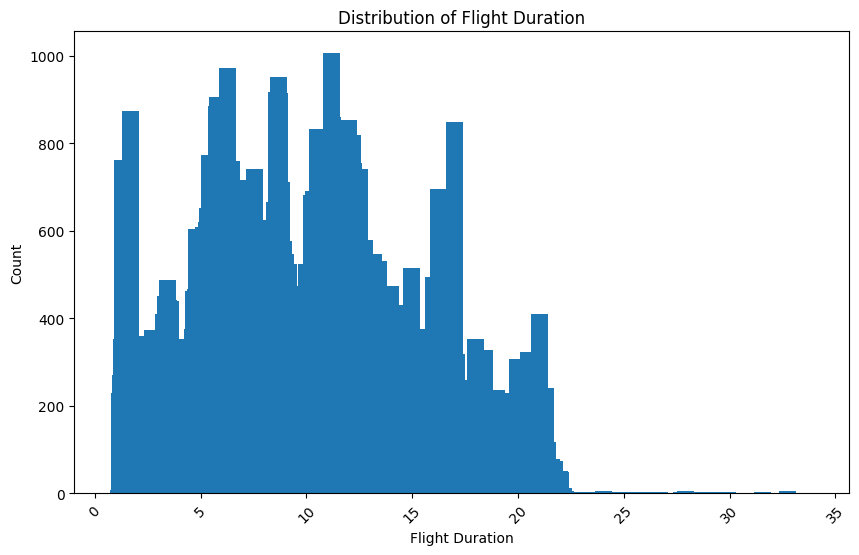

In [ ]:
# Contar la frecuencia de cada duración de vuelo
duration_counts = df["Flight Duration"].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(duration_counts.index, duration_counts.values)
plt.xlabel("Flight Duration")
plt.ylabel("Count")
plt.title("Distribution of Flight Duration")
plt.xticks(rotation=45)
plt.show()

Se puede observar que existen vuelos muy largos por lo que se verificará.

In [ ]:
# Agrupar por combinación única de aeropuertos y calcular la duración mínima y máxima del vuelo
result = df.groupby(['Departure Airport', 'Arrival Airport'])['Flight Duration'].agg(['min', 'max']).reset_index()

# Renombrar columnas
result.columns = ['Departure Airport', 'Arrival Airport', 'Min Flight Duration', 'Max Flight Duration']
result

,Departure Airport,Arrival Airport,Min Flight Duration,Max Flight Duration
0,BOS,JFK,1.200000,29.016667
1,BOS,LAS,2.733333,27.900000
2,BOS,LAX,3.150000,31.566667
3,BOS,ORD,1.716667,11.800000
4,BOS,SFO,3.450000,29.366667
5,JFK,BOS,1.100000,33.600000
6,JFK,LAS,2.483333,16.133333
7,JFK,LAX,2.750000,25.200000
8,JFK,ORD,1.650000,10.400000
9,JFK,SFO,3.150000,24.016667


Se puede observar que existen vuelos bien largos, pero esto puede deberse a que existen vuelos con varias escalas que podrían tomar mucha horas por lo que tiene sentido. Ahora se observará si existen vuelos con muchas horas de espera en rutas directas es decir con 0 número de escalas.

In [ ]:
# Filtrar solo vuelos sin escalas
df2 = df[df['Number Of Stops'] == 0].copy()

# Agrupar por combinación única de aeropuertos y calcular la duración mínima y máxima del vuelo
result = df2.groupby(['Departure Airport', 'Arrival Airport'])['Flight Duration'].agg(['min', 'max']).reset_index()

# Renombrar columnas
result.columns = ['Departure Airport', 'Arrival Airport', 'Min Flight Duration', 'Max Flight Duration']
result

,Departure Airport,Arrival Airport,Min Flight Duration,Max Flight Duration
0,BOS,JFK,1.200000,1.700000
1,BOS,LAS,2.733333,3.266667
2,BOS,LAX,3.150000,3.866667
3,BOS,ORD,1.716667,2.116667
4,BOS,SFO,3.450000,4.016667
5,JFK,BOS,1.100000,1.816667
6,JFK,LAS,2.483333,3.033333
7,JFK,LAX,2.750000,3.683333
8,JFK,ORD,1.650000,2.166667
9,JFK,SFO,3.150000,3.883333


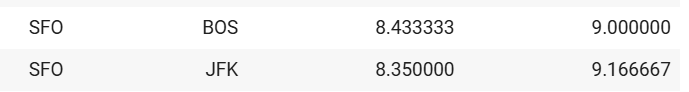

Según nuestra base de datos, se observa que el tiempo de un vuelo sin escalas de San Francisco International Airport (SFO) a Boston Logan International Airport (BOS) dura como mínimo 8.4 horas y como máximo 9 horas. Sin embargo, al averiguar el tiempo de vuelo sin escalas de San Francisco International Airport (SFO) a Boston Logan International Airport (BOS) suele estar entre 5 horas y 30 minutos y 6 horas, dependiendo de las condiciones del viento y la aerolínea. Por tanto, se observa un error.

Otro ejemplo es el siguiente:


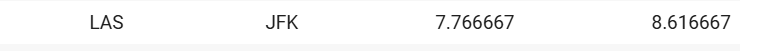

El tiempo de vuelo sin escalas desde Las Vegas (LAS - Harry Reid International Airport) a Nueva York (JFK - John F. Kennedy International Airport) suele estar entre 4 horas y 45 minutos y 5 horas y 30 minutos, dependiendo de la aerolínea, las condiciones del viento y la ruta específica. Por tanto, los datos están errados o puede haber otro motivo.

Al observar la data se encuentra que sí hay algunas inconsistencias en los tiempos de vuelo que llaman la atención:

- BOS - LAS (2.73 - 3.26 horas) y BOS - LAX (3.15 - 3.87 horas)

Estos valores parecen extrañamente bajos. Un vuelo directo de Boston (BOS) a Las Vegas (LAS) normalmente dura alrededor de 5 horas, y a Los Ángeles (LAX) unas 6 horas.

- JFK - LAS (2.48 - 3.03 horas) y JFK - LAX (2.75 - 3.68 horas)

Un vuelo directo de Nueva York (JFK) a Las Vegas (LAS) dura aproximadamente 5 horas y 30 minutos.

- De JFK a Los Ángeles (LAX) debería durar unas 6 horas.
Estos valores son demasiado bajos, lo que sugiere que hay un error en la base de datos.

- LAS - BOS (7.93 - 8.53 horas) y LAS - JFK (7.76 - 8.61 horas)

Estos tiempos son excesivamente altos para vuelos directos.
Un vuelo de Las Vegas a Boston o Las Vegas a JFK debería tomar unas 5 horas.
Esto sugiere que se están considerando vuelos con escalas o que los tiempos han sido mal registrados.

- ORD - LAS (1.8 - 2.3 horas) y ORD - LAX (2.27 - 2.82 horas)

El tiempo de vuelo de Chicago (ORD) a Las Vegas (LAS) suele estar entre 3h 30min y 4h, por lo que el valor en la tabla es demasiado bajo.
Lo mismo ocurre con ORD - LAX, que normalmente dura unas 4h 30min.

- SFO - BOS (8.43 - 9.00 horas) y SFO - JFK (8.35 - 9.17 horas)
Estos valores son demasiado altos. Normalmente, un vuelo directo de San Francisco (SFO) a Boston (BOS) o SFO a JFK dura aproximadamente 5h 30min a 6h.
Estos valores sugieren que se han incluido vuelos con escalas.

Conclusión:

Parece que los datos están incorrectos y posiblemente reflejan valores erróneos o vuelos con una escala en el cálculo.

Por oto lado, se ha pensado que las diferencias de huso horario pueden afectar los datos si los tiempos de vuelo se calculan en base a las horas locales de salida y llegada, en lugar del tiempo total de vuelo en horas reales.

Vuelos de Este a Oeste (Ejemplo: BOS → LAX, JFK → LAS)

Cuando viajas de la costa Este (Eastern Time, UTC-5) a la costa Oeste (Pacific Time, UTC-8), el reloj en el destino muestra un horario 3 horas antes.
Si el tiempo de vuelo real es 6 horas, pero se calcula restando la hora de llegada menos la hora de salida (en hora local), el resultado parecería ser 3 horas, lo que explicaría los valores anormalmente bajos.

Vuelos de Oeste a Este (Ejemplo: LAX → BOS, LAS → JFK)

Aquí ocurre lo contrario. Viajar de la costa Oeste a la costa Este significa que el reloj avanza 3 horas en el destino. Un vuelo real de 5 horas podría parecer de 8 horas si se usa la diferencia entre horas locales.



Por tanto, debido a que tenemos los horarios de salida y llegada, calcularemos  la duración real restando los tiempos en UTC en lugar de las horas locales.


In [ ]:

import pytz
# Diccionario con los husos horarios de los aeropuertos más comunes
timezones = {
    'BOS': 'America/New_York',
    'JFK': 'America/New_York',
    'LAX': 'America/Los_Angeles',
    'LAS': 'America/Los_Angeles',
    'ORD': 'America/Chicago',
    'SFO': 'America/Los_Angeles'
}

# Convertir a datetime y ajustar a UTC
def convert_to_utc(row):
    dep_tz = pytz.timezone(timezones.get(row['Departure Airport'], 'UTC'))
    arr_tz = pytz.timezone(timezones.get(row['Arrival Airport'], 'UTC'))

    dep_time = dep_tz.localize(pd.to_datetime(row['Departure Date']))
    arr_time = arr_tz.localize(pd.to_datetime(row['Arrival Date']))

    dep_time_utc = dep_time.astimezone(pytz.utc)
    arr_time_utc = arr_time.astimezone(pytz.utc)

    return (arr_time_utc - dep_time_utc).total_seconds() / 3600  # Convertir a horas

# Aplicar la corrección de duración
df['Corrected Flight Duration'] = df.apply(convert_to_utc, axis=1)

# Agrupar por combinación única de aeropuertos y calcular la duración mínima y máxima del vuelo
result = df.groupby(['Departure Airport', 'Arrival Airport'])['Corrected Flight Duration'].agg(['min', 'max']).reset_index()

# Renombrar columnas
result.columns = ['Departure Airport', 'Arrival Airport', 'Min Flight Duration', 'Max Flight Duration']

In [ ]:
result

,Departure Airport,Arrival Airport,Min Flight Duration,Max Flight Duration
0,BOS,JFK,1.200000,1.700000
1,BOS,LAS,2.733333,3.266667
2,BOS,LAX,3.150000,3.866667
3,BOS,ORD,1.716667,2.116667
4,BOS,SFO,3.450000,4.016667
5,JFK,BOS,1.100000,1.816667
6,JFK,LAS,2.483333,3.033333
7,JFK,LAX,2.750000,3.683333
8,JFK,ORD,1.650000,2.166667
9,JFK,SFO,3.150000,3.883333


**BOS → LAS (Antes: ~3h, Ahora: ~5.7h - 6.3h):** Ahora refleja correctamente un vuelo directo de Boston a Las Vegas, que típicamente toma unas 5h 30m a 6h.

**JFK → LAX (Antes: ~3h, Ahora: ~5.7h - 6.7h):** Un vuelo sin escalas de Nueva York (JFK) a Los Ángeles (LAX) suele tomar alrededor de 6 horas, por lo que los valores ahora son correctos.

**LAS → BOS (Antes: ~8h, Ahora: ~4.9h - 5.5h):** Antes el vuelo era demasiado largo, probablemente debido a la diferencia horaria. Ahora, el rango coincide con la duración real.

**ORD → LAX (Antes: ~2h, Ahora: ~4.2h - 4.8h):** Chicago (ORD) a Los Ángeles (LAX) realmente toma entre 4h y 5h, así que ahora el valor está corregido.

**SFO → BOS (Antes: ~8h, Ahora: ~5.4h - 6h):** Este vuelo suele durar unas 5h 30m a 6h, por lo que ahora los datos tienen sentido.


En general, ahora los tiempos de vuelo parecen mucho más razonables y alineados con los tiempos de vuelo reales. En conclusión, las correcciones de zona horaria resolvieron el problema. Ahora los valores reflejan duraciones reales de vuelos sin escalas y ya no existen valoresores absurdamente cortos ni excesivamente largos, lo que indica que los datos ahora son más confiables.

In [ ]:
df

,Searched Date,Departure Date,Arrival Date,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Route,Airline,Cabin,Price,Days Before Departure,Day of Week_departure,Month_departure,Season_departure,Flight Duration,Corrected Flight Duration
0,2024-06-30,2024-07-16 23:48:00,2024-07-17 15:03:00,1,LAS,BOS,1,ATL,Spirit Airlines,Economy,83,16,Tuesday,7,Summer,15.250000,12.250000
1,2024-06-30,2024-07-16 09:34:00,2024-07-16 19:43:00,0,LAS,BOS,1,EWR,Spirit Airlines,Economy,100,16,Tuesday,7,Summer,10.150000,7.150000
2,2024-06-30,2024-07-16 23:48:00,2024-07-17 15:03:00,1,LAS,BOS,1,ATL,Spirit Airlines,Economy,78,16,Tuesday,7,Summer,15.250000,12.250000
3,2024-06-30,2024-07-16 08:30:00,2024-07-16 19:37:00,0,LAS,BOS,1,IAH,Spirit Airlines,Economy,100,16,Tuesday,7,Summer,11.116667,8.116667
4,2024-06-30,2024-07-16 07:00:00,2024-07-16 16:36:00,0,LAS,BOS,1,ORD,American Airlines,Basic Economy,148,16,Tuesday,7,Summer,9.600000,6.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317255,2024-06-29,2024-07-16 13:10:00,2024-07-16 23:53:00,0,LAS,BOS,1,DEN,United Airlines,Basic Economy,219,17,Tuesday,7,Summer,10.716667,7.716667
317256,2024-06-29,2024-07-16 06:20:00,2024-07-16 17:02:00,0,LAS,BOS,1,PHX,American Airlines,Basic Economy,218,17,Tuesday,7,Summer,10.700000,7.700000
317257,2024-06-29,2024-07-16 23:30:00,2024-07-17 10:17:00,1,LAS,BOS,1,IAD,United Airlines,Economy,198,17,Tuesday,7,Summer,10.783333,7.783333
317258,2024-06-29,2024-07-16 10:50:00,2024-07-17 00:18:00,1,LAS,BOS,1,JFK,JetBlue,Blue Basic,154,17,Tuesday,7,Summer,13.466667,10.466667


In [ ]:
df.drop('Flight Duration', axis=1, inplace=True)

# Cambiar el nombre de la columna 'Airline' a 'Airline Name'
df.rename(columns={"Corrected Flight Duration": "Flight Duration"}, inplace=True)

### f. Cabina

In [ ]:
# Agrupar por aerolínea y obtener los tipos de cabina únicos
cabinas_por_aerolinea = df.groupby('Airline')['Cabin'].unique().reset_index()

# Renombrar la columna para mayor claridad
cabinas_por_aerolinea.rename(columns={'cabin_type': 'unique_cabin_types'}, inplace=True)

cabinas_por_aerolinea

,Airline,Cabin
0,Alaska Airlines,"[Saver, Main, First]"
1,Allegiant Air,[Economy]
2,"Allegiant Air, Breeze Airways",[Economy]
3,"Allegiant Air, Spirit Airlines",[Economy]
4,"Allegiant Air, Sun Country Air",[Economy]
5,American Airlines,"[Basic Economy, Main Cabin, Main Cabin Flex, M..."
6,"Avelo Airlines, Spirit Airlines",[Economy]
7,Avianca,[Economy]
8,"Avianca, Spirit Airlines",[Economy]
9,"Breeze Airways, Spirit Airlines",[No Flex Fare]


In [ ]:
# Get the unique airline names using pd.unique()
unique_airlines = pd.unique(df['Cabin'])
print(unique_airlines)

['Economy' 'Basic Economy' 'Blue Basic' 'Saver' 'Standard' 'Main Cabin'
 'Blue' 'Main' 'First' 'Mint' 'UltraBasic' 'Economy Plus'
 'Blue Refundable' 'BizFare' 'Business/First' 'Main Cabin Basic'
 'Main Cabin Flex' 'No Flex Fare' 'Premium Economy' 'Main Select'
 'PorterClassic Basic' 'Discount' 'Comfort +'
 'Business/First (fully refundable)' 'Mixed' 'Economy (fully refundable)']


Como tenemos muchas categorías, agrupamos las categorías en clases principales para simplificar el análisis.



In [ ]:
# Calcular el precio promedio por categoría
category_price = df.groupby('Cabin')['Price'].mean().reset_index()

# Ordenar por precio promedio de menor a mayor
category_price = category_price.sort_values(by='Price', ascending=True)

# Mostrar las categorías ordenadas con sus medias
category_list = category_price.values.tolist()
for category, price in category_list:
    print(f"{category}: {price:.2f}")

# También puedes retornar las listas ordenadas si deseas trabajar con ellas
ordered_categories = category_price['Cabin'].tolist()
ordered_means = category_price['Price'].tolist()
print("\nCategorías ordenadas:", ordered_categories)
print("Medias ordenadas:", ordered_means)

Standard: 173.03
Blue Basic: 191.00
BizFare: 196.32
No Flex Fare: 206.97
Basic Economy: 225.81
Blue: 337.23
Economy: 338.03
Mixed: 365.50
Main Select: 381.00
Saver: 384.45
Blue Refundable: 402.72
PorterClassic Basic: 403.98
Comfort +: 424.67
UltraBasic: 503.13
Main Cabin: 537.94
Premium Economy: 624.87
Economy Plus: 659.08
Main: 671.06
Main Cabin Basic: 672.25
Main Cabin Flex: 810.43
Business/First: 823.53
First: 941.91
Mint: 1438.54
Discount: 1730.00
Business/First (fully refundable): 2009.67
Economy (fully refundable): 2550.00

Categorías ordenadas: ['Standard', 'Blue Basic', 'BizFare', 'No Flex Fare', 'Basic Economy', 'Blue', 'Economy', 'Mixed', 'Main Select', 'Saver', 'Blue Refundable', 'PorterClassic Basic', 'Comfort +', 'UltraBasic', 'Main Cabin', 'Premium Economy', 'Economy Plus', 'Main', 'Main Cabin Basic', 'Main Cabin Flex', 'Business/First', 'First', 'Mint', 'Discount', 'Business/First (fully refundable)', 'Economy (fully refundable)']
Medias ordenadas: [173.02706144539957, 1

In [ ]:
# Filtrar las filas donde la cabina sea "Discount"
discount_rows = df[df['Cabin'] == 'Discount']

# Mostrar las aerolíneas asociadas a "Discount" si hay una columna para aerolíneas
if 'Airline' in df.columns:
    print(discount_rows[['Airline', 'Cabin', 'Price']])
else:
    print("No se encontró una columna 'Airline' en el dataset. Aquí están las filas filtradas:")
    print(discount_rows)
discount_rows

                 Airline     Cabin  Price
39065   TAP AIR PORTUGAL  Discount   1857
261196  TAP AIR PORTUGAL  Discount   1603


,Searched Date,Departure Date,Arrival Date,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Route,Airline,Cabin,Price,Days Before Departure,Day of Week_departure,Month_departure,Season_departure,Flight Duration
39065,2024-06-29,2024-07-12 18:00:00,2024-07-13 20:05:00,1,ORD,JFK,1,LIS,TAP AIR PORTUGAL,Discount,1857,13,Friday,7,Summer,25.083333
261196,2024-07-02,2024-07-17 18:00:00,2024-07-18 20:05:00,1,ORD,JFK,1,LIS,TAP AIR PORTUGAL,Discount,1603,15,Wednesday,7,Summer,25.083333


Se elimininarán, son solo dos registros con estos datos altos. Esta categoría cuando se ha buscado en la aerolinea no existe por lo que se procederá a eliminar estos registros y tampoco existe la ruta.

In [ ]:
# Filtrar y eliminar los registros donde la cabina sea "Discount"
df = df[df['Cabin'] != 'Discount']

Agrupamos las categorías teniendo en cuenta su precio y sus características.

In [ ]:
# Crear una función para asignar categorías más compactas
def categorize_cabin_detailed(cabin):
    if cabin in ['Standard', 'Blue Basic', 'BizFare', 'No Flex Fare', 'Basic Economy', 'Blue', 'Economy', 'Saver']:
        return 'Economy'
    elif cabin in ['Mixed', 'PorterClassic Basic', 'Blue Refundable', 'Main Select', 'Comfort +',
                   'UltraBasic', 'Main Cabin', 'Premium Economy', 'Economy Plus', 'Main', 'Main Cabin Basic','Economy (fully refundable)']:
        return 'Premium Economy'
    elif cabin in ['Business/First', 'Main Cabin Flex', 'Mint','First','Business/First (fully refundable)']:
        return 'Clase Business/First'
    else:
        return 'Otros'

<ipython-input-31-e7ceb01b19c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cabin Group'] = df['Cabin'].apply(categorize_cabin_detailed)
<ipython-input-31-e7ceb01b19c8>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


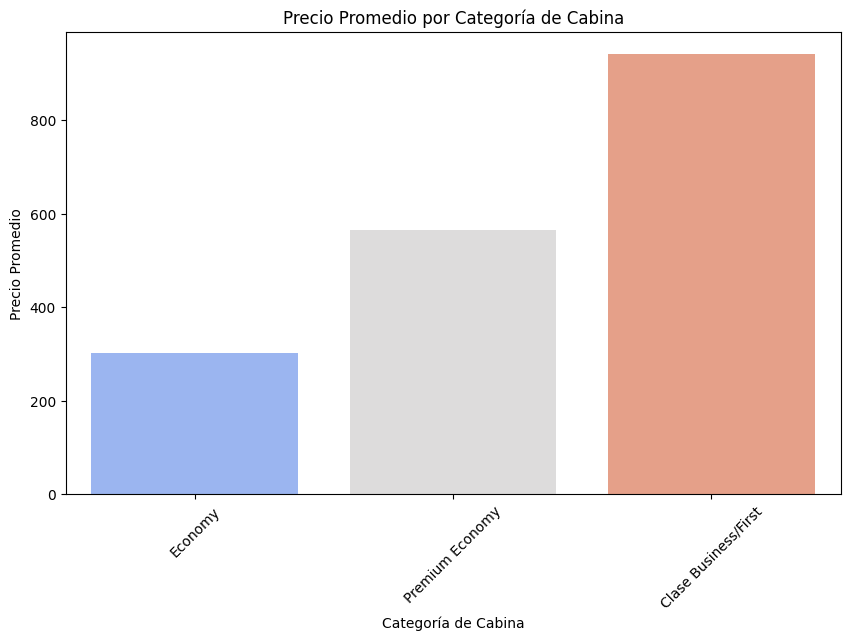

In [ ]:
# Aplicar la función de categorización al DataFrame
df['Cabin Group'] = df['Cabin'].apply(categorize_cabin_detailed)

# Calcular el precio promedio por categoría de cabina
category_price = df.groupby('Cabin Group')['Price'].mean().reset_index()

# Ordenar por precio promedio de menor a mayor
category_price = category_price.sort_values(by='Price', ascending=True)

# Graficar las categorías de cabina
plt.figure(figsize=(10, 6))
sns.barplot(
    data=category_price,
    x='Cabin Group',
    y='Price',
    palette='coolwarm'
)
plt.title('Precio Promedio por Categoría de Cabina')
plt.xlabel('Categoría de Cabina')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=45)  # Rotar etiquetas para legibilidad
plt.show()


In [ ]:
# Verificar si hay valores nulos en la columna 'Cabin Group'
print("Valores nulos en 'Cabin Group':", df['Cabin Group'].isnull().sum())

Valores nulos en 'Cabin Group': 0


In [ ]:
#Eliinar columna que ya no se utilizará.
df = df.drop(['Cabin'], axis=1)

### g. Aerolínea:

Se puede observar que existen combinaciones de aerolíneas como *Spirit Airlines, Allegiant Air*. Esto sucede porque existen vuelos con escalas que utilizan diferentes aerolíneas en conjunto para llegar al destino. Por tanto, a esas combinaciones, se registrará como  *Multiple airlines	*

In [ ]:
df.groupby('Airline').size()

,0
Airline,
Alaska Airlines,57136
Allegiant Air,15
"Allegiant Air, Breeze Airways",11
"Allegiant Air, Spirit Airlines",39
"Allegiant Air, Sun Country Air",11
American Airlines,51746
"Avelo Airlines, Spirit Airlines",10
Avianca,419
"Avianca, Spirit Airlines",14


In [ ]:
df['Airline Type'] = df['Airline'].apply(lambda x: 'Multiple airlines' if ',' in x else x)

In [ ]:
df.groupby('Airline Type').size()

,0
Airline Type,
Alaska Airlines,57136
Allegiant Air,15
American Airlines,51746
Avianca,419
Cape Air,84
Delta,55578
Frontier,3747
Hawaiian Airlines,15
JetBlue,14882


In [ ]:
df

,Searched Date,Departure Date,Arrival Date,Flight Lands Next Day,Departure Airport,Arrival Airport,Number Of Stops,Route,Airline,Price,Days Before Departure,Day of Week_departure,Month_departure,Season_departure,Flight Duration,Cabin Group,Airline Type
0,2024-06-30,2024-07-16 23:48:00,2024-07-17 15:03:00,1,LAS,BOS,1,ATL,Spirit Airlines,83,16,Tuesday,7,Summer,12.250000,Economy,Spirit Airlines
1,2024-06-30,2024-07-16 09:34:00,2024-07-16 19:43:00,0,LAS,BOS,1,EWR,Spirit Airlines,100,16,Tuesday,7,Summer,7.150000,Economy,Spirit Airlines
2,2024-06-30,2024-07-16 23:48:00,2024-07-17 15:03:00,1,LAS,BOS,1,ATL,Spirit Airlines,78,16,Tuesday,7,Summer,12.250000,Economy,Spirit Airlines
3,2024-06-30,2024-07-16 08:30:00,2024-07-16 19:37:00,0,LAS,BOS,1,IAH,Spirit Airlines,100,16,Tuesday,7,Summer,8.116667,Economy,Spirit Airlines
4,2024-06-30,2024-07-16 07:00:00,2024-07-16 16:36:00,0,LAS,BOS,1,ORD,American Airlines,148,16,Tuesday,7,Summer,6.600000,Economy,American Airlines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317255,2024-06-29,2024-07-16 13:10:00,2024-07-16 23:53:00,0,LAS,BOS,1,DEN,United Airlines,219,17,Tuesday,7,Summer,7.716667,Economy,United Airlines
317256,2024-06-29,2024-07-16 06:20:00,2024-07-16 17:02:00,0,LAS,BOS,1,PHX,American Airlines,218,17,Tuesday,7,Summer,7.700000,Economy,American Airlines
317257,2024-06-29,2024-07-16 23:30:00,2024-07-17 10:17:00,1,LAS,BOS,1,IAD,United Airlines,198,17,Tuesday,7,Summer,7.783333,Economy,United Airlines
317258,2024-06-29,2024-07-16 10:50:00,2024-07-17 00:18:00,1,LAS,BOS,1,JFK,JetBlue,154,17,Tuesday,7,Summer,10.466667,Economy,JetBlue


In [ ]:
df.drop('Airline', axis=1, inplace=True)

# Cambiar el nombre de la columna 'Airline' a 'Airline Name'
df.rename(columns={"Airline Type": "Airline"}, inplace=True)

### h. Variables categ+oricas

In [ ]:
df.columns

Index(['Searched Date', 'Departure Date', 'Arrival Date',
       'Flight Lands Next Day', 'Departure Airport', 'Arrival Airport',
       'Number Of Stops', 'Route', 'Price', 'Days Before Departure',
       'Day of Week_departure', 'Month_departure', 'Season_departure',
       'Flight Duration', 'Cabin Group', 'Airline'],
      dtype='object')

In [ ]:
# Convertir las variables seleccionadas a tipo categórico
categorical_vars = [
    'Flight Lands Next Day',
    'Departure Airport',
    'Arrival Airport',
    'Number Of Stops',
    'Route',
    'Airline',
    'Day of Week_departure',
    'Season_departure',
    'Cabin Group'
]

# Convertir a categóricas
for var in categorical_vars:
    df[var] = df[var].astype('category')

# Verificar la conversión
print("Variables categóricas:")
print(df[categorical_vars].dtypes)

# Asegurarse de que las demás variables permanezcan en su tipo original
print("\nOtras variables:")
print(df.drop(columns=categorical_vars).dtypes)


Variables categóricas:
Flight Lands Next Day    category
Departure Airport        category
Arrival Airport          category
Number Of Stops          category
Route                    category
Airline                  category
Day of Week_departure    category
Season_departure         category
Cabin Group              category
dtype: object

Otras variables:
Searched Date            datetime64[ns]
Departure Date           datetime64[ns]
Arrival Date             datetime64[ns]
Price                             int64
Days Before Departure             int64
Month_departure                   int32
Flight Duration                 float64
dtype: object


## Análisis Exploratorio - Relación entre variables

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 317258 entries, 0 to 317259
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Searched Date          317258 non-null  datetime64[ns]
 1   Departure Date         317258 non-null  datetime64[ns]
 2   Arrival Date           317258 non-null  datetime64[ns]
 3   Flight Lands Next Day  317258 non-null  category      
 4   Departure Airport      317258 non-null  category      
 5   Arrival Airport        317258 non-null  category      
 6   Number Of Stops        317258 non-null  category      
 7   Route                  317258 non-null  category      
 8   Price                  317258 non-null  int64         
 9   Days Before Departure  317258 non-null  int64         
 10  Day of Week_departure  317258 non-null  category      
 11  Month_departure        317258 non-null  int32         
 12  Season_departure       317258 non-null  category 

In [ ]:
df.describe()

,Searched Date,Departure Date,Arrival Date,Price,Days Before Departure,Month_departure,Flight Duration
count,317258,317258,317258,317258.000000,317258.000000,317258.00000,317258.000000
mean,2024-06-29 21:34:09.922776064,2024-08-03 09:09:35.155803904,2024-08-03 18:35:15.353938688,359.883010,33.981192,7.61102,9.438922
min,2024-06-27 00:00:00,2024-07-03 00:07:00,2024-07-03 06:30:00,15.000000,6.000000,7.00000,1.100000
25%,2024-06-28 00:00:00,2024-07-12 11:46:00,2024-07-12 21:18:00,217.000000,12.000000,7.00000,6.966667
50%,2024-06-30 00:00:00,2024-07-15 10:20:00,2024-07-15 19:47:00,316.000000,15.000000,7.00000,9.083333
75%,2024-07-02 00:00:00,2024-07-24 07:00:00,2024-07-24 15:14:00,457.000000,22.000000,7.00000,11.833333
max,2024-07-03 00:00:00,2024-12-11 23:59:00,2024-12-12 21:30:00,3688.000000,167.000000,12.00000,34.566667
std,NaN,NaN,NaN,214.944665,45.069664,1.45804,3.833020


### Price

**Distribución de precios**
Analizaremos la distribución de la variable Price para entender su rango y forma.

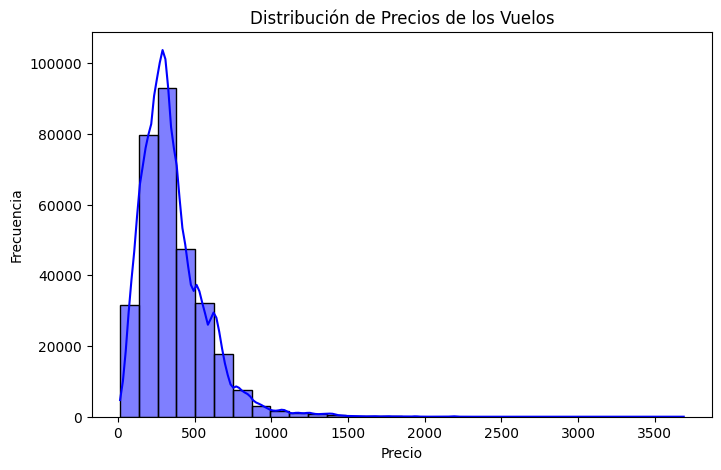

In [ ]:
# Histograma de precios
plt.figure(figsize=(8, 5))
sns.histplot(df['Price'], kde=True, bins=30, color='blue')
plt.title('Distribución de Precios de los Vuelos')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()


identificación de outliers

In [ ]:
from scipy.stats import zscore

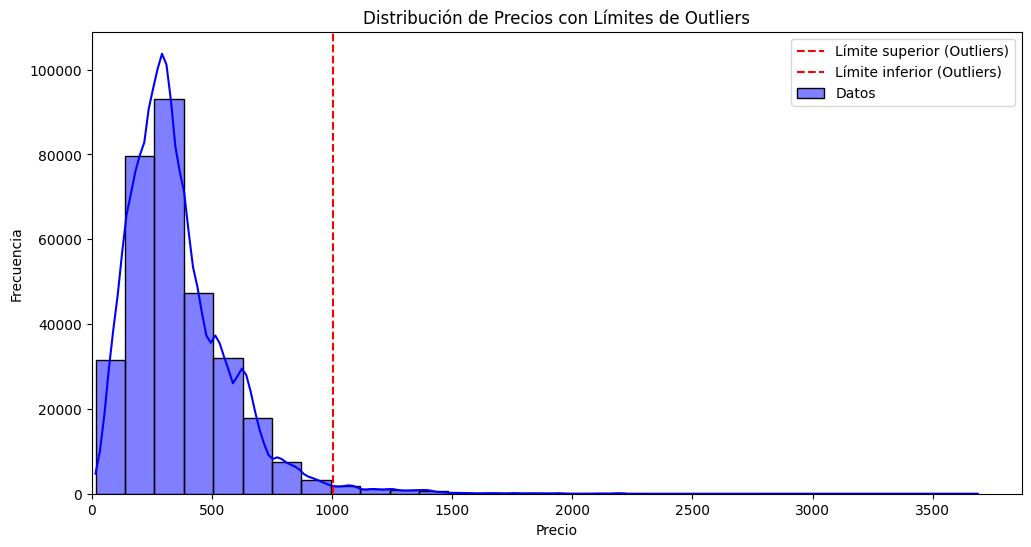

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Calcular el Z-Score para la variable 'Price'
df['Price_zscore'] = zscore(df['Price'])

# Identificar outliers usando el umbral (Z-Score > 3 o < -3)
outliers = df[df['Price_zscore'].abs() > 3]

# Calcular límites de outliers
upper_limit = df['Price'].mean() + 3 * df['Price'].std()
lower_limit = df['Price'].mean() - 3 * df['Price'].std()

# Filtrar valores negativos si los hubiera (opcional para precios)
df = df[df['Price'] >= 0]

# Graficar histograma con límites
plt.figure(figsize=(12, 6))
sns.histplot(df['Price'], bins=30, kde=True, color='blue', label='Datos')

# Líneas verticales para los límites de outliers
plt.axvline(x=upper_limit, color='red', linestyle='--', label='Límite superior (Outliers)')
plt.axvline(x=max(lower_limit, 0), color='red', linestyle='--', label='Límite inferior (Outliers)')

plt.title('Distribución de Precios con Límites de Outliers')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.xlim(left=0)  # Asegurar que el eje X empieza en 0
plt.legend()
plt.show()


In [ ]:
# Crear un nuevo DataFrame excluyendo los outliers
df_no_outliers = df[df['Price_zscore'].abs() <= 3].copy()

# Eliminar la columna 'Price_zscore' del nuevo DataFrame
df_no_outliers.drop(columns=['Price_zscore'], inplace=True)

# Verificar el resultado
print(df_no_outliers.head())  # Muestra las primeras filas del DataFrame sin outliers
print(f"Número de filas sin outliers: {df_no_outliers.shape[0]}")


  Searched Date      Departure Date        Arrival Date Flight Lands Next Day  \
0    2024-06-30 2024-07-16 23:48:00 2024-07-17 15:03:00                     1   
1    2024-06-30 2024-07-16 09:34:00 2024-07-16 19:43:00                     0   
2    2024-06-30 2024-07-16 23:48:00 2024-07-17 15:03:00                     1   
3    2024-06-30 2024-07-16 08:30:00 2024-07-16 19:37:00                     0   
4    2024-06-30 2024-07-16 07:00:00 2024-07-16 16:36:00                     0   

  Departure Airport Arrival Airport Number Of Stops Route  Price  \
0               LAS             BOS               1   ATL     83   
1               LAS             BOS               1   EWR    100   
2               LAS             BOS               1   ATL     78   
3               LAS             BOS               1   IAH    100   
4               LAS             BOS               1   ORD    148   

   Days Before Departure Day of Week_departure  Month_departure  \
0                     16             

In [ ]:
df=df_no_outliers.copy()

### **Flight Duration**

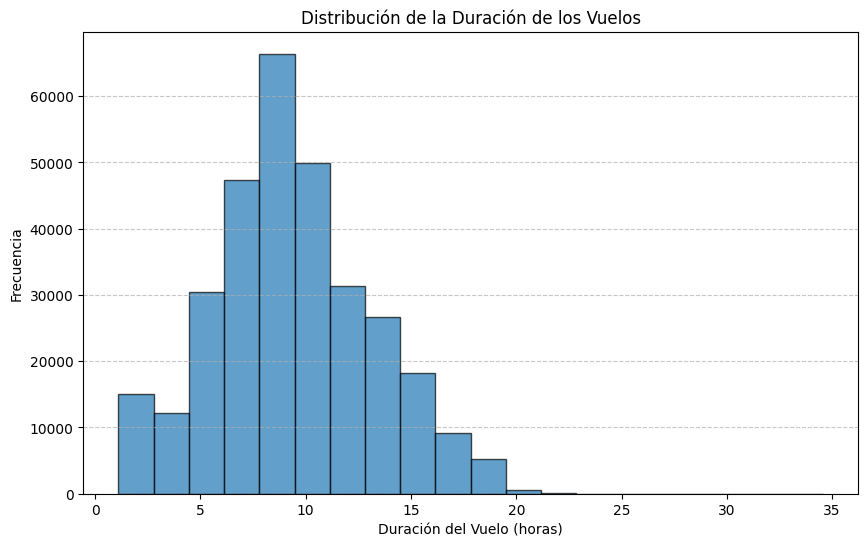

In [ ]:
import matplotlib.pyplot as plt

# Crear el gráfico de duración de vuelos
plt.figure(figsize=(10, 6))
plt.hist(df['Flight Duration'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Duración del Vuelo (horas)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Duración de los Vuelos')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()


### **Number Of Stops**

**Impacto del número de escalas en el precio**:
Analizaremos cómo varía el precio según la variable Number Of Stops.

<ipython-input-49-3cbd5625e703>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stops_prices = df.groupby('Number Of Stops')['Price'].mean().reset_index()
<ipython-input-49-3cbd5625e703>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stops_prices, x='Number Of Stops', y='Price', palette='coolwarm')


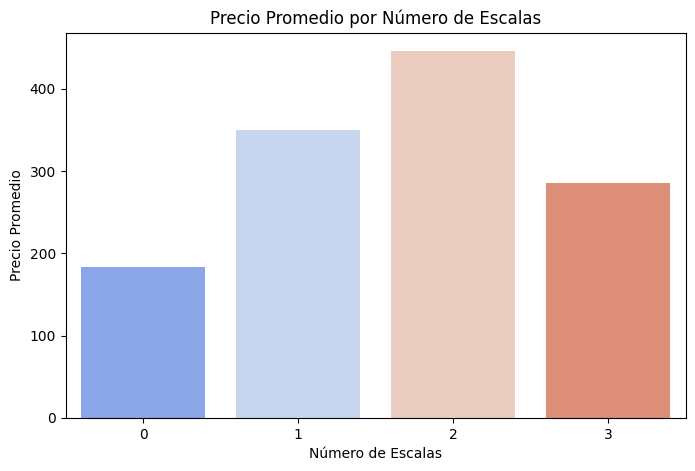

In [ ]:
# Precio promedio por número de escalas
stops_prices = df.groupby('Number Of Stops')['Price'].mean().reset_index()

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(data=stops_prices, x='Number Of Stops', y='Price', palette='coolwarm')
plt.title('Precio Promedio por Número de Escalas')
plt.xlabel('Número de Escalas')
plt.ylabel('Precio Promedio')
plt.show()


### **Cabin**

**Precio Promedio por Tipo de Cabina**

<ipython-input-50-818e902e2a00>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cabin_price = df.groupby('Cabin Group')['Price'].mean().reset_index()
<ipython-input-50-818e902e2a00>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


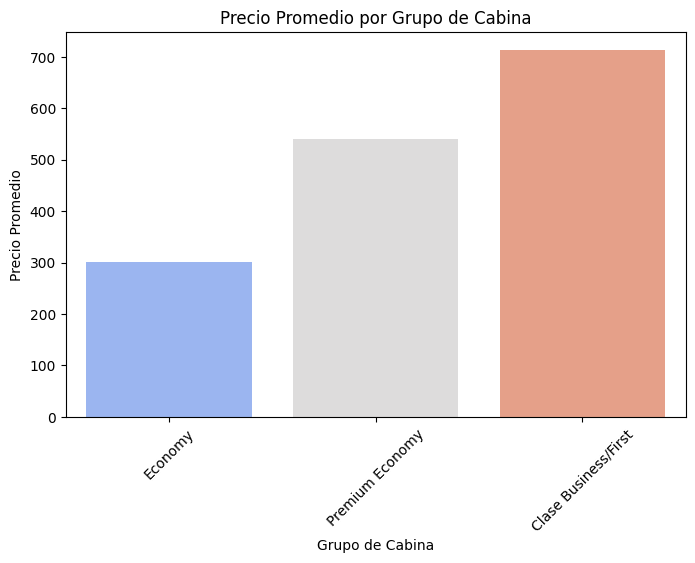

In [ ]:
# Calcular el precio promedio por grupo de cabina
cabin_price = df.groupby('Cabin Group')['Price'].mean().reset_index()

# Ordenar por precio promedio de menor a mayor
cabin_price = cabin_price.sort_values(by='Price', ascending=True)

# Garantizar el orden en el gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(
    data=cabin_price,
    x='Cabin Group',
    y='Price',
    palette='coolwarm',
    order=cabin_price['Cabin Group']  # Especificar el orden explícito
)
plt.title('Precio Promedio por Grupo de Cabina')
plt.xlabel('Grupo de Cabina')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=45)  # Rotar etiquetas si es necesario
plt.show()


### **Airline**

**Precio promedio por aerolínea:**

<ipython-input-51-08c2c76f9d0d>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  airline_price = df.groupby('Airline')['Price'].mean().reset_index().sort_values(by='Price', ascending=False)
<ipython-input-51-08c2c76f9d0d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


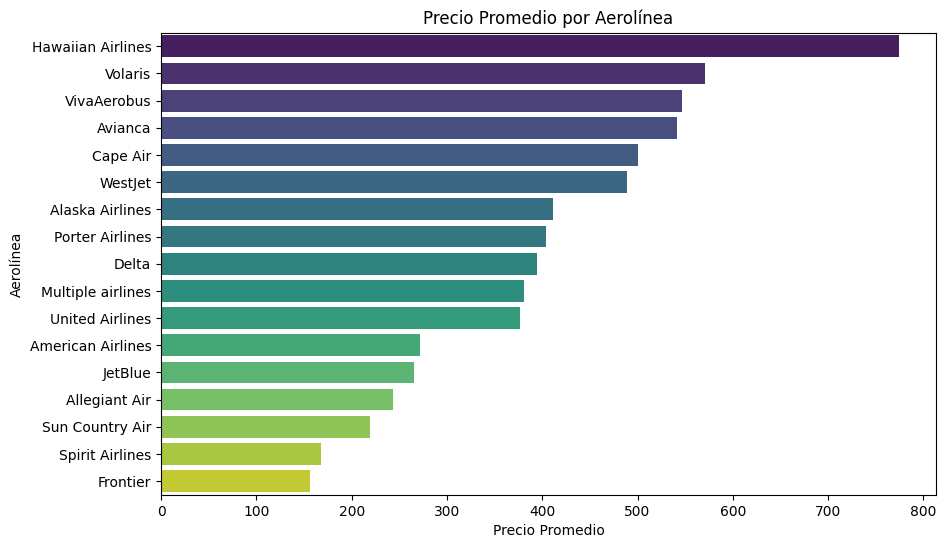

In [ ]:
# Calcular el precio promedio por aerolínea y ordenar de mayor a menor
airline_price = df.groupby('Airline')['Price'].mean().reset_index().sort_values(by='Price', ascending=False)

# Gráfico de barras con orden explícito
plt.figure(figsize=(10, 6))
sns.barplot(
    data=airline_price,
    x='Price',
    y='Airline',
    palette='viridis',
    order=airline_price['Airline']  # Especificar el orden explícito
)
plt.title('Precio Promedio por Aerolínea')
plt.xlabel('Precio Promedio')
plt.ylabel('Aerolínea')
plt.show()


###**Departure Date:**
De esta variable se puede obtener más variables para el análisis

####  **Days Before Departure**

**Precio promedio y Dias antes de la salida**

In [ ]:
df.columns

Index(['Searched Date', 'Departure Date', 'Arrival Date',
       'Flight Lands Next Day', 'Departure Airport', 'Arrival Airport',
       'Number Of Stops', 'Route', 'Price', 'Days Before Departure',
       'Day of Week_departure', 'Month_departure', 'Season_departure',
       'Flight Duration', 'Cabin Group', 'Airline'],
      dtype='object')

In [ ]:
# Group by 'Days Before Departure' and calculate the average price
flights_summary = df.groupby('Days Before Departure')['Price'].mean().reset_index()

In [ ]:
# Verify the grouping and aggregation
print(flights_summary.head())

   Days Before Departure       Price
0                      6  483.923580
1                      7  367.522985
2                      8  373.879738
3                      9  373.831677
4                     10  368.805324


In [ ]:
# Calculate the correlation between 'Days Before Departure' and 'Price'
correlation = flights_summary[['Days Before Departure', 'Price']].corr().iloc[0, 1]
print(f"Correlation between Days Before Departure and Price: {correlation}")

Correlation between Days Before Departure and Price: -0.7645188019171215


Este valor representa una fuerte correlación negativa entre los días antes de la fecha de salida y el precio del vuelo. Esto significa que, en general, mientras más cerca estés de la fecha de salida, mayor será el precio del boleto aéreo. Este fenómeno tiene importantes implicancias para los usuarios que buscan ahorrar dinero al planificar sus viajes.

Las tarifas suelen aumentar drásticamente en los últimos días o incluso semanas previas a la salida.


Los precios también están influenciados por la temporada alta y baja.

La fuerte correlación negativa entre los días antes de la salida y el precio confirma una regla general de los viajes: planificar con tiempo es la clave para ahorrar dinero en vuelos.

In [ ]:
# Crear una columna con rangos de días antes de la salida
bins = [0, 7, 14, 21, 30,  float('inf')]  # Incluye un rango superior para valores mayores a 60
labels = ['0-7', '8-14', '15-21', '22-30', '30+']  # Etiquetas que corresponden a los intervalos

# Agregar la columna categórica al DataFrame
df['Days Range'] = pd.cut(df['Days Before Departure'], bins=bins, labels=labels, include_lowest=True)

# Verificar la distribución de los rangos
print("Distribución de vuelos por rango de días:")
print(df['Days Range'].value_counts())


Distribución de vuelos por rango de días:
Days Range
8-14     137499
15-21     88287
30+       55822
22-30     23067
0-7        7977
Name: count, dtype: int64


<ipython-input-57-42b1fa1b9d44>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_per_range = df.groupby('Days Range')['Price'].mean().reset_index()
<ipython-input-57-42b1fa1b9d44>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_per_range, x='Days Range', y='Price', palette='coolwarm')


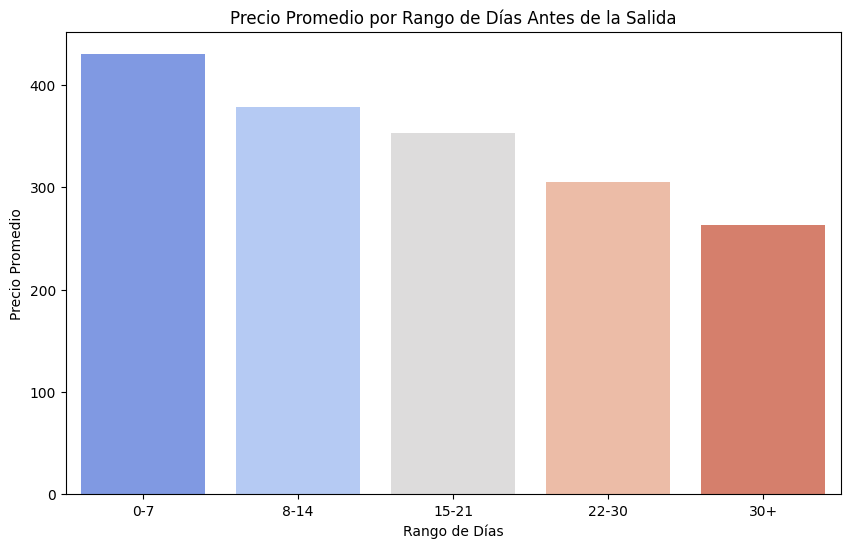

In [ ]:
# Calcular el precio promedio por rango
avg_price_per_range = df.groupby('Days Range')['Price'].mean().reset_index()

# Graficar los precios promedios por rango
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_price_per_range, x='Days Range', y='Price', palette='coolwarm')
plt.title('Precio Promedio por Rango de Días Antes de la Salida')
plt.xlabel('Rango de Días')
plt.ylabel('Precio Promedio')
plt.show()


In [ ]:
df.drop(['Days Range'], axis=1, inplace=True)

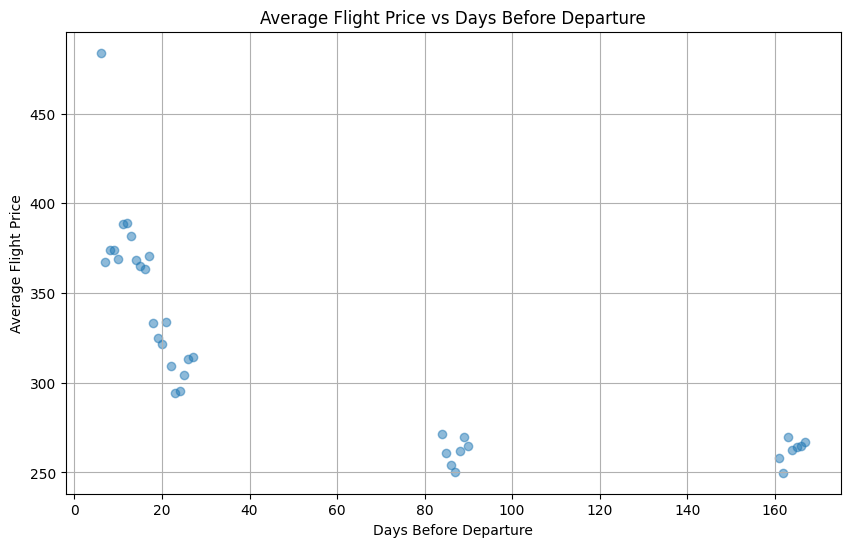

In [ ]:
# Plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(flights_summary['Days Before Departure'], flights_summary['Price'], alpha=0.5)
plt.title('Average Flight Price vs Days Before Departure')
plt.xlabel('Days Before Departure')
plt.ylabel('Average Flight Price')
plt.grid(True)
plt.show()

También podemos visualizar el precio medio del vuelo por temporadA. Por tanto podríamos crear una nueva variable donde se identifique las estaciones del año teniendo en cuenta que deberían ser las estaciones del año correspondiente a estados unidos.

Primavera: Marzo, abril y mayo.

Verano: Junio, julio y agosto.

Otoño: Septiembre, octubre y noviembre.

Invierno: Diciembre, enero y febrero.

#### **Season_departure**

<ipython-input-60-f9a3f2c56761>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Season_departure', y='Price', palette='coolwarm')


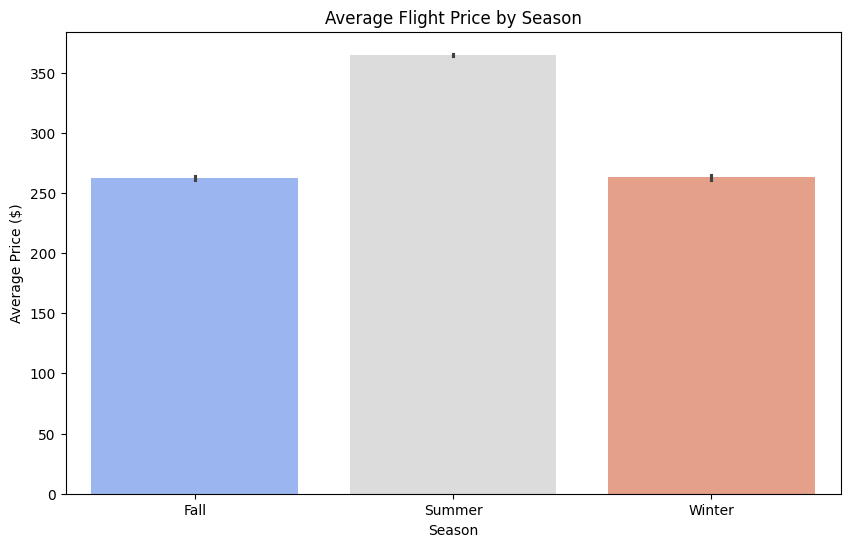

In [ ]:
# Gráfico de precios por temporada
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Season_departure', y='Price', palette='coolwarm')
plt.title('Average Flight Price by Season')
plt.xlabel('Season')
plt.ylabel('Average Price ($)')
plt.show()

#### Day of Week_departure

<ipython-input-61-bf4c91971de1>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_day = df.groupby('Day of Week_departure')['Price'].mean()


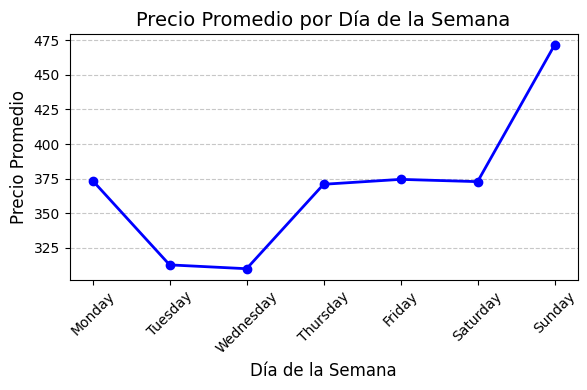

In [ ]:
# Graficar los días de la semana y el precio promedio
avg_price_by_day = df.groupby('Day of Week_departure')['Price'].mean()


# Graficar con una línea en lugar de barras
plt.figure(figsize=(6, 4))
avg_price_by_day.plot(kind='line', marker='o', color='blue', linestyle='-', linewidth=2)

# Configurar etiquetas y título
plt.title('Precio Promedio por Día de la Semana', fontsize=14)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Precio Promedio', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Los días más económicos parecen ser martes y miércoles, mientras que viernes , sábado y domingo  son días típicamente más caros, con mayor variabilidad de precios.

In [ ]:
df.columns

Index(['Searched Date', 'Departure Date', 'Arrival Date',
       'Flight Lands Next Day', 'Departure Airport', 'Arrival Airport',
       'Number Of Stops', 'Route', 'Price', 'Days Before Departure',
       'Day of Week_departure', 'Month_departure', 'Season_departure',
       'Flight Duration', 'Cabin Group', 'Airline'],
      dtype='object')

### SELECCIÓN DE VARIABLES

Después de observar y hacer las tranformaciones necesarias de las variables así como la creación de nuevas, hemos decidido eliminar algunas variables por las siguientes razones.


**Searched Date:** Es redundante porque ya tengo `Days Before Departure`.

**Departure Date:** Es redundante si ya tengo `Season`,` Day of Week` y `Month`.

**Route:** Redundante con Departure Airport, Arrival Airport, y Number Of Stops.Ya que una vez obtenido de donde llega y a dónde va el avión, junto con su npumero de escalas. Ya no es necesario obtener este dato.

In [ ]:
df2=df.copy()

In [ ]:
df2.drop(['Searched Date', 'Departure Date', 'Route'], axis=1, inplace=True)


**Arrival Date:** No es relevante directamente para predecir precios.


In [ ]:
# Eliminamos 'Arrival Date' porque no es útil para regresión
df2.drop(columns=['Arrival Date'], inplace=True)


**Flight Lands Next Day:** Consecuencia de otras variables.

In [ ]:
df2.drop(columns=['Flight Lands Next Day'], inplace=True)

In [ ]:
df2.columns

Index(['Departure Airport', 'Arrival Airport', 'Number Of Stops', 'Price',
       'Days Before Departure', 'Day of Week_departure', 'Month_departure',
       'Season_departure', 'Flight Duration', 'Cabin Group', 'Airline'],
      dtype='object')

### **EVALUACIÓN VIF**

Manejar variables categóricas

In [ ]:
# Aplicar Label Encoding a las columnas categóricas
for col in df2.select_dtypes(include=['object', 'category']).columns:
    encoder = LabelEncoder()
    df2[col] = encoder.fit_transform(df2[col])

Verificar si exite multicoolinealidad en los datos ya que esto puede afectar en el futuro al modelo.

In [ ]:
# Agregar constante para el cálculo del VIF
X_with_constant = add_constant(df2.drop('Price', axis=1))

# Calcular VIF para cada variable
vif_data = pd.DataFrame({
    "Variable": X_with_constant.columns,
    "VIF": [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]
})

# Mostrar resultados
print(vif_data.sort_values(by="VIF", ascending=False))


                 Variable          VIF
0                   const  2488.019907
6         Month_departure   130.312933
4   Days Before Departure   125.366553
7        Season_departure     2.022490
8         Flight Duration     1.742376
3         Number Of Stops     1.724680
5   Day of Week_departure     1.297682
1       Departure Airport     1.102556
2         Arrival Airport     1.094953
9             Cabin Group     1.049586
10                Airline     1.035410


Month_departure (VIF = 130.30):

Es probable que esté correlacionada con Season_departure, ya que ambas se refieren a períodos de tiempo.  Por tanto, se eliminará y nos quedaremos con Season_departure.



Days Before Departure (VIF = 125.32):

Podría estar correlacionada con otras variables relacionadas con el tiempo, como Month_departure o Day of Week_departure. Esta variable es clave para la predicción por lo que no se eliminará y tomará en cuenta las otras variables


Eliminar variables redundantes y recalcular VIF

In [ ]:
df2.drop(['Month_departure'], axis=1, inplace=True)
# El mes está relacionacionado con la estación. Terner ambas pueden causar multiolinealidad

In [ ]:
# Agregar constante para el cálculo del VIF
X_with_constant = add_constant(df2.drop('Price', axis=1))

# Calcular VIF para cada variable
vif_data = pd.DataFrame({
    "Variable": X_with_constant.columns,
    "VIF": [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]
})

# Mostrar resultados
print(vif_data.sort_values(by="VIF", ascending=False))


                Variable        VIF
0                  const  40.644798
7        Flight Duration   1.741970
3        Number Of Stops   1.724311
4  Days Before Departure   1.370903
5  Day of Week_departure   1.227447
6       Season_departure   1.149916
1      Departure Airport   1.102556
2        Arrival Airport   1.094889
8            Cabin Group   1.049583
9                Airline   1.035299


Todas las variables tienen un VIF < 5, lo que significa que no hay multicolinealidad significativa.

## Clustering: K-MEANS
- Implementar el algoritmo de K-Means para segmentar los datos en grupos.
- Analizar los resultados obtenidos y discutir la coherencia y relevancia de los clusters identificado

-----


Para realizar el k-means, eliminanos la variable *precio*. Esto por que el clustering se usa para descubrir patrones en los datos sin depender de la variable objetivo (Price). Si incluyéramos Price, el modelo agruparía vuelos solo en función del costo, lo cual no es el objetivo aquí.
Queremos segmentar vuelos según factores operativos y características del viaje, no solo por precio.

-----


In [ ]:
# Eliminar la columna "Price" para preparar los datos
df_kmeans = df2.drop('Price', axis=1).copy()

In [ ]:
# Definir las variables numéricas y categóricas
numeric_features = ['Number Of Stops', 'Days Before Departure', 'Flight Duration']
categorical_features = ['Departure Airport', 'Arrival Airport', 'Day of Week_departure',
                         'Season_departure', 'Cabin Group', 'Airline']

# Transformador para variables numéricas
numeric_transformer = StandardScaler()

# Transformador para variables categóricas
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

#### **Método del Codo, Calinski-Harabasz y  Silhouette Score**

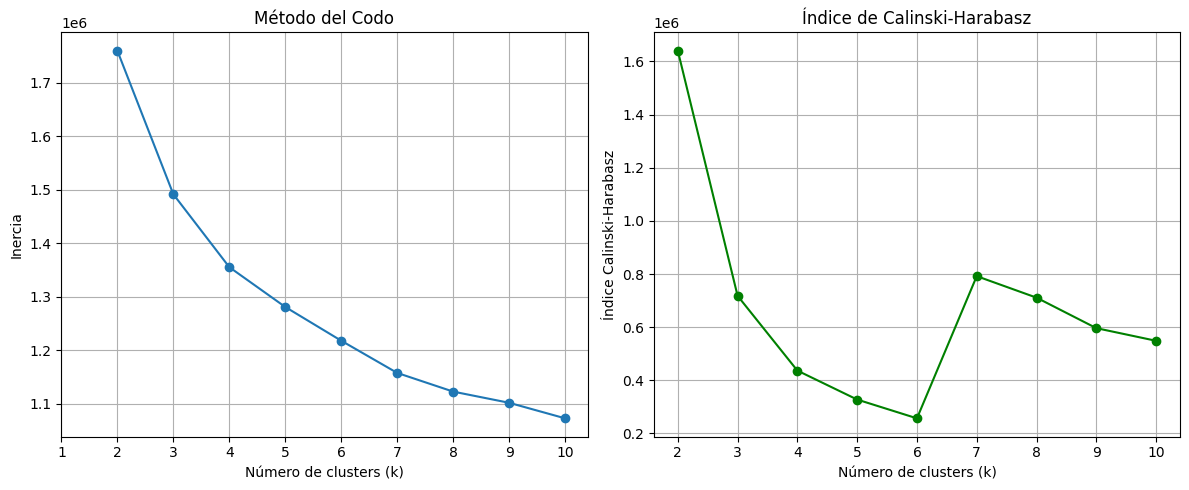

In [ ]:
# Variables para almacenar resultados
inertias = []
calinski_harabasz_scores = []
K = range(2, 11)  # El índice requiere al menos 2 clusters

# Iterar por cada valor de k
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    pipeline_tmp = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Preprocesamiento (definido previamente)
        ('kmeans', kmeans)
    ])
    pipeline_tmp.fit(df_kmeans)
    labels = pipeline_tmp.named_steps['kmeans'].labels_  # Obtener etiquetas del modelo

    # Calcular métricas
    inertias.append(kmeans.inertia_)
    calinski_harabasz_scores.append(calinski_harabasz_score(df_kmeans, labels))

# Gráficos del Método del Codo y Calinski-Harabasz
plt.figure(figsize=(12, 5))

# Subgráfico 1: Método del Codo
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), [None] + inertias, marker='o', linestyle='-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.xticks(range(1, 11))
plt.grid(True)

# Subgráfico 2: Calinski-Harabasz
plt.subplot(1, 2, 2)
plt.plot(K, calinski_harabasz_scores, marker='o', linestyle='-', color='green')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Índice Calinski-Harabasz')
plt.title('Índice de Calinski-Harabasz')
plt.xticks(K)
plt.grid(True)

plt.tight_layout()
plt.show()



1. **Método del Codo**:
   - El "codo" parece estar en \(k = 3\), donde la reducción de la inercia comienza a estabilizarse.
   - \(k = 3\) podría ser un buen equilibrio entre simplicidad y calidad del agrupamiento.

2. **Índice de Calinski-Harabasz**:
   - El valor máximo se alcanza en \(k = 2\), indicando una fuerte cohesión y separación.
   - Sin embargo, hay un segundo pico más pequeño en \(k = 7\), que podría ser una opción alternativa.

**Conclusión:**

La elección óptima parece ser \(k = 2\) según el **Silhouette Score** y el **Índice de Calinski-Harabasz**. Sin embargo, \(k = 3\) podría considerarse como una alternativa válida si priorizas una mayor granularidad en el agrupamiento, tal como sugiere el **Método del Codo**.



**Silhouette Score**

In [ ]:
df_kmeans_transformed = preprocessor.fit_transform(df_kmeans).toarray()

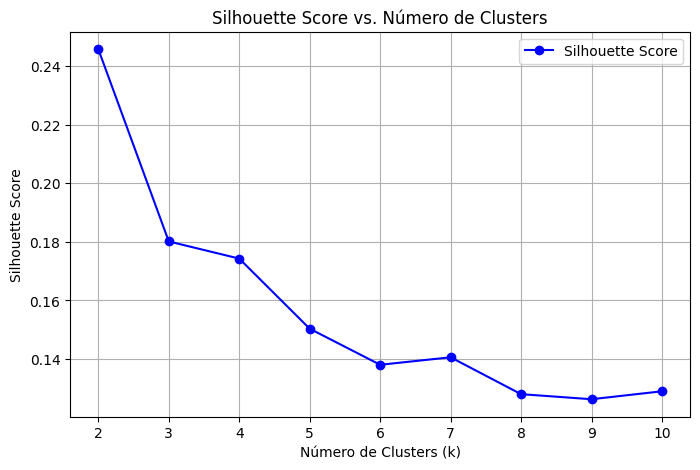

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

# Submuestreo del 10% para el cálculo del Silhouette Score
sample_fraction = 0.1
silhouette_scores = []
k_values = list(range(2, 11))  # Valores de k a evaluar

# Transformar datos y convertir a array denso
df_kmeans_transformed = preprocessor.fit_transform(df_kmeans).toarray()

# Iterar sobre los valores de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    pipeline_tmp = Pipeline(steps=[('kmeans', kmeans)])

    # Ajustar modelo en datos transformados
    pipeline_tmp.fit(df_kmeans_transformed)
    labels = pipeline_tmp.named_steps['kmeans'].labels_

    # Seleccionar índices aleatorios para submuestreo
    np.random.seed(42)  # Asegura reproducibilidad
    sample_indices = np.random.choice(df_kmeans_transformed.shape[0],
                                      size=int(df_kmeans_transformed.shape[0] * sample_fraction),
                                      replace=False)

    # Extraer la muestra
    sample_data = df_kmeans_transformed[sample_indices]
    sample_labels = labels[sample_indices]

    # Calcular Silhouette Score en la muestra
    silhouette_scores.append(silhouette_score(sample_data, sample_labels))

# 📊 Gráfico del Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b', label='Silhouette Score')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Número de Clusters')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()


 A partir de los datos observados,se observa lo diguiente:

1. **Máximo en k=2**:
   - La puntuación más alta ocurre con **k=2**, lo que indica que los datos están mejor representados por dos clústeres según esta métrica.

2. **Disminución drástica entre k=2 y k=3**:
   - El Silhouette Score disminuye significativamente cuando se pasa de **k=2** a **k=3**, lo que sugiere que agregar más clústeres no mejora la cohesión de los clústeres.


**Visualizar los clusters para k=2 y k=3 a través de la técnica  PCA (Análisis de Componentes Principales).**

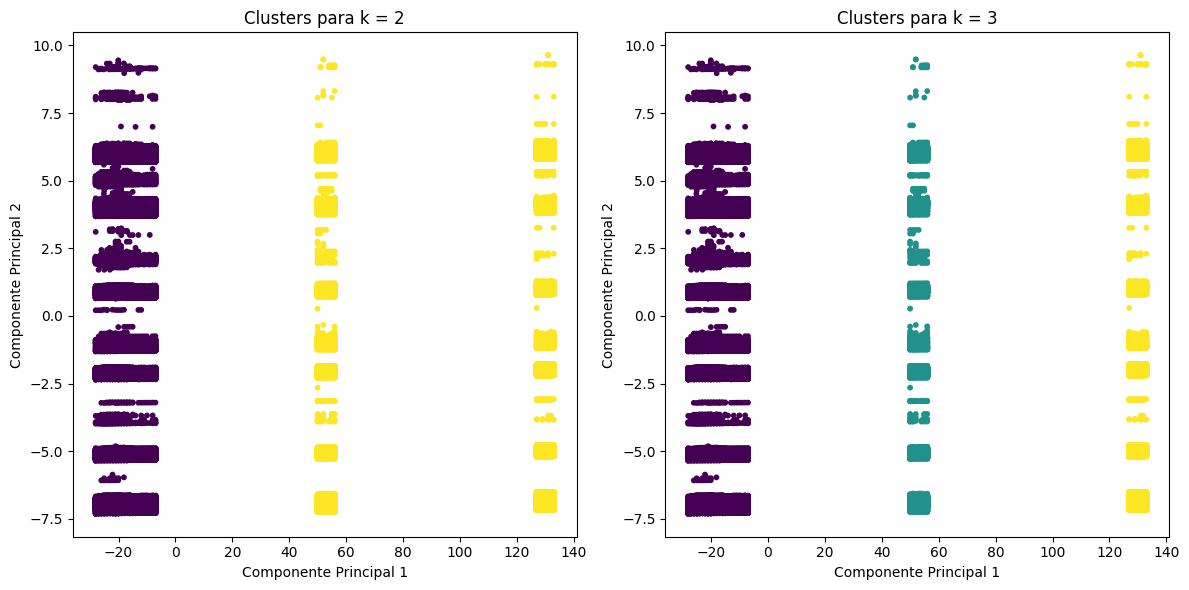

In [ ]:
# Definir el rango de clusters que vamos a graficar
cluster_values = [2, 3]

# Reducir la dimensionalidad de los datos para visualización
pca = PCA(n_components=2)
df_kmeans_reduced = pca.fit_transform(df_kmeans)

plt.figure(figsize=(12, 6))

# Visualizar clusters para cada valor de k
for i, k in enumerate(cluster_values, 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_kmeans)

    # Crear el subgráfico
    plt.subplot(1, 2, i)
    plt.scatter(df_kmeans_reduced[:, 0], df_kmeans_reduced[:, 1], c=labels, cmap='viridis', s=10)
    plt.title(f'Clusters para k = {k}')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')

plt.tight_layout()
plt.show()


1. **Gráfico \(k = 2\)**:
   - Se observa una clara separación entre los dos clusters (representados por los colores morado y amarillo).
   - Esto coincide con el **Silhouette Score**, que indicó que \(k = 2\) tiene la mejor separación y cohesión.

2. **Gráfico \(k = 3\)**:
   - Aparece un tercer cluster. Sin embargo, el nuevo cluster parece estar "dividiendo" un cluster previo en \(k = 2\), en lugar de identificar un patrón claramente distinto.
   - Esto podría indicar que \(k = 3\) no mejora significativamente la separación ni la calidad de los clusters.

**Conclusión:**
- **\(k = 2\)** parece ser la mejor elección, ya que tiene una clara separación y está respaldado por el **Silhouette Score** y el **Índice de Calinski-Harabasz**.

**Modelo con el punto óptimo**` K=2`

Características promedio por cluster:
              Price  Days Before Departure  Month_departure  Flight Duration  \
Cluster                                                                        
0        364.890211              14.535557         7.000000         9.393839   
1        262.620795             123.876411        10.433951         9.352229   

         Cluster  
Cluster           
0            0.0  
1            1.0  

Promedio de la variable 'Price' por cluster:
Cluster
0    364.890211
1    262.620795
Name: Price, dtype: float64


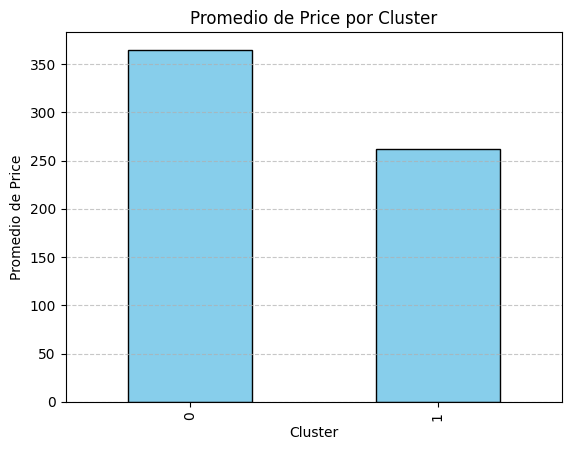

In [ ]:
# Elegir el valor de k óptimo (en este caso, k=2)
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_kmeans)

# 1. Características promedio por cluster
# Seleccionar solo columnas numéricas para calcular promedios
numeric_columns = df.select_dtypes(include=['number']).columns
cluster_means = df.groupby('Cluster')[numeric_columns].mean()

# Mostrar resultados de las características promedio
print("Características promedio por cluster:")
print(cluster_means)

# 2. Impacto de los clusters en una variable específica (ejemplo: 'Price')
if 'Price' in df.columns:
    price_by_cluster = df.groupby('Cluster')['Price'].mean()
    print("\nPromedio de la variable 'Price' por cluster:")
    print(price_by_cluster)

    # Graficar el impacto de los clusters en 'Price'
    price_by_cluster.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Promedio de Price por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Promedio de Price')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("\nLa columna 'Price' no está disponible en los datos.")


#### 1. **Características promedio por cluster**:
- **Cluster 0**:
  - **Precio promedio**: **364.89** (más alto).
  - **Días antes de la salida**: **14.53** (baja antelación).
  - **Mes de salida promedio**: **7.00 (julio)**.
  - **Duración del vuelo**: **9.39** (similar al otro cluster).

- **Cluster 1**:
  - **Precio promedio**: **262.62** (más bajo).
  - **Días antes de la salida**: **123.88** (alta antelación).
  - **Mes de salida promedio**: **10.43 (octubre)**.
  - **Duración del vuelo**: **9.35** (prácticamente igual al Cluster 0).

#### 2. **Promedio de la variable 'Price' por cluster**:
- El **precio promedio** es significativamente más alto para el **Cluster 0**, lo que sugiere que reservar vuelos con poca antelación (alrededor de 14 días) está asociado a precios más altos.
- El **Cluster 1**, con una antelación promedio de 123 días, tiene precios mucho más bajos.

---

### Conclusión:
- Este resultado destaca una relación clara entre la antelación en la reserva y el precio promedio:
  - **Cluster 0** podría representar viajeros que reservan en el último minuto o para eventos inesperados, donde el precio tiende a ser más alto.
  - **Cluster 1** representa viajeros planificados que reservan con mucha antelación, logrando precios más económicos.

- **Duración del vuelo**: La duración promedio es muy similar entre los clusters, lo que indica que este factor no tiene un impacto significativo en la segmentación.




Por tanto, después de realizar este análisis podríamos enfocarnos en promociones o descuentos en viajeros de **Cluster 0** para incentivar reservas anticipadas y evitar precios altos de última hora.

Y para el **Cluster 1**, se puede mantener precios competitivos pero aseguranos de optimizar la rentabilidad al captar viajeros planificados.


## **MODELO DE REGRESIÓN**

- Aplicar un modelo de regresión (lineal o polinómico) para predecir una
variable continua a partir de una o varias variables independientes.
- Evaluar la precisión y eficacia del modelo a través de métricas adecuada

----


### Análisis previo

In [ ]:
df2.columns

Index(['Departure Airport', 'Arrival Airport', 'Number Of Stops', 'Price',
       'Days Before Departure', 'Day of Week_departure', 'Season_departure',
       'Flight Duration', 'Cabin Group', 'Airline'],
      dtype='object')

Obvervar las correlaciones que tienen nuestras variables epxlicativas con las variable objetivo

Correlación con 'Price':
Price                    1.000000
Cabin Group              0.386726
Number Of Stops          0.365529
Flight Duration          0.288016
Arrival Airport          0.024492
Season_departure         0.009197
Airline                 -0.024234
Departure Airport       -0.047339
Day of Week_departure   -0.175833
Days Before Departure   -0.207904
Name: Price, dtype: float64


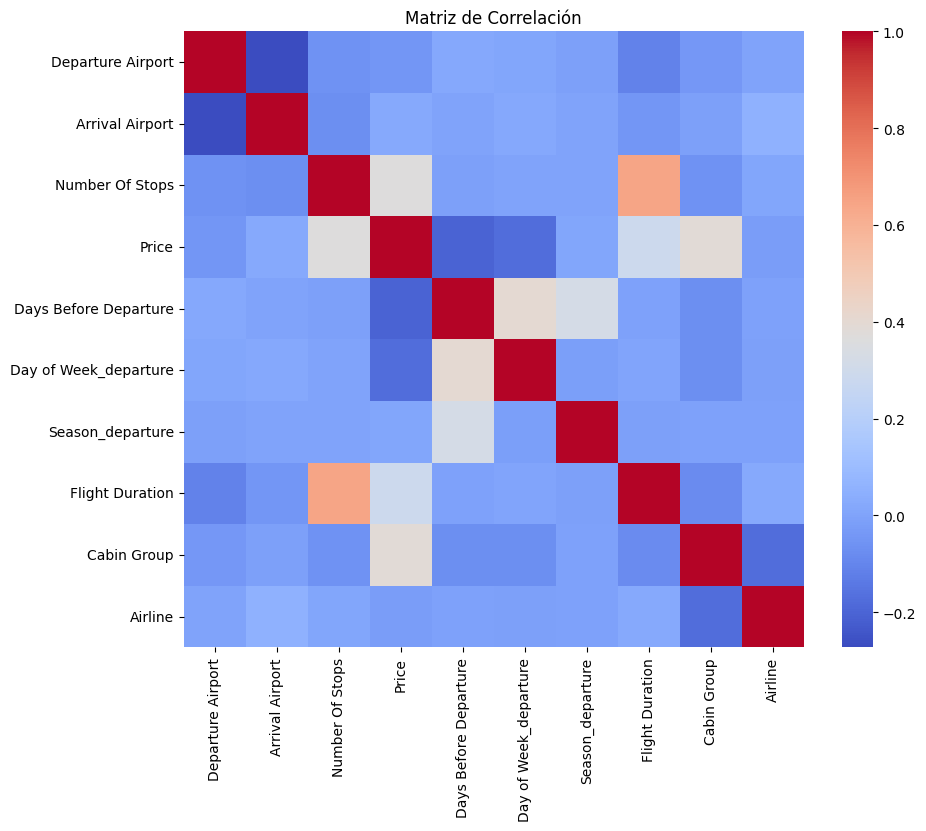

In [ ]:
# Calcular matriz de correlación
correlation_matrix = df2.corr()

# Mostrar correlación con la variable objetivo (Price)
target_corr = correlation_matrix['Price'].sort_values(ascending=False)
print("Correlación con 'Price':")
print(target_corr)

# Visualizar la matriz de correlación
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()


**Variables con correlación positiva:**
* Cabin Group (0.3867): La clase de cabina tiene la correlación más alta. Esto indica que los boletos en clases superiores (business, primera clase) son más caros.
* Number Of Stops (0.3655): A más escalas, mayor precio. Aunque los vuelos directos suelen ser más costosos, algunos itinerarios con muchas escalas pueden incrementar el costo debido a rutas poco convencionales o mayor demanda.
* Flight Duration (0.2336): Los vuelos más largos tienden a ser más caros, lo que tiene sentido dado el mayor consumo de combustible y costos operativos.
Variables con correlación cercana a cero (relación débil con el precio)
* Arrival Airport (0.0245): El aeropuerto de llegada tiene una correlación muy baja con el precio, lo que sugiere que no hay un impacto claro.
* Season_departure (0.0092): La estación del año en la que se viaja tiene un impacto casi nulo, lo cual es inusual. Puede deberse a que los efectos de temporada están capturados en otras variables como Days Before Departure.

**Variables con correlación negativa:**
* Airline (-0.0242): La aerolínea tiene un impacto leve y negativo. Esto podría indicar que aerolíneas más económicas dominan en los datos.
* Departure Airport (-0.0473): El aeropuerto de salida tiene una pequeña relación negativa con el precio. Tal vez algunos aeropuertos de origen tengan precios más bajos debido a mayor competencia o volumen de vuelos.
* Day of Week_departure (-0.1758): Salir ciertos días de la semana (probablemente entre semana) tiende a reducir el precio.
Days Before Departure (-0.2079): Comprar con más anticipación reduce el precio, lo cual es un comportamiento típico en la industria aérea.


**Conclusión**

La clase de cabina y el número de escalas son los principales factores que elevan el precio.

Comprar con anticipación y viajar ciertos días de la semana tiende a reducir el costo.

Variables como el aeropuerto de llegada, la aerolínea y la estación del año tienen poco impacto en el precio.

**Análisis de variables categóricas**

Para variables categóricas, evaluamos la relación entre cada categoría y su variable objetivo a través del uso de ANOVA


In [ ]:
# Variables categóricas detectadas para ANOVA
categorical_features_encoded = ['Departure Airport', 'Arrival Airport', 'Number Of Stops',
                                 'Day of Week_departure', 'Season_departure', 'Cabin Group']

# Resultados de ANOVA
anova_results_encoded = []

# Calcular ANOVA para cada variable categórica
for cat in categorical_features_encoded:
    groups = [group['Price'].values for _, group in df2.groupby(cat, observed=False) if len(group) > 1]

    if len(groups) > 1:  # Verifica que hay suficientes grupos
        try:
            f_stat, p_value = stats.f_oneway(*groups)
            anova_results_encoded.append({'Variable': cat, 'F-Statistic': f_stat, 'P-Value': p_value})
        except Exception as e:
            anova_results_encoded.append({'Variable': cat, 'F-Statistic': None, 'P-Value': None})
            print(f"Error al procesar la variable {cat}: {e}")
    else:
        anova_results_encoded.append({'Variable': cat, 'F-Statistic': None, 'P-Value': None})

# Convertir resultados a DataFrame
anova_df_encoded = pd.DataFrame(anova_results_encoded)
anova_df_encoded = anova_df_encoded.sort_values(by='P-Value', na_position='last')

# Mostrar resultados al usuario
anova_df_encoded

,Variable,F-Statistic,P-Value
0,Departure Airport,2569.733182,0.0
1,Arrival Airport,1933.296126,0.0
2,Number Of Stops,18222.750464,0.0
3,Day of Week_departure,3780.840436,0.0
4,Season_departure,7408.789317,0.0
5,Cabin Group,61265.495127,0.0


Al ver los resultados, observamos que todas las variables categóricas analizadas tienen un impacto significativo en el precio, por lo que deben ser incluidas en el modelo.

<ipython-input-82-4d4c1ed1d698>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[col] = df_subset[col].astype('category').cat.codes


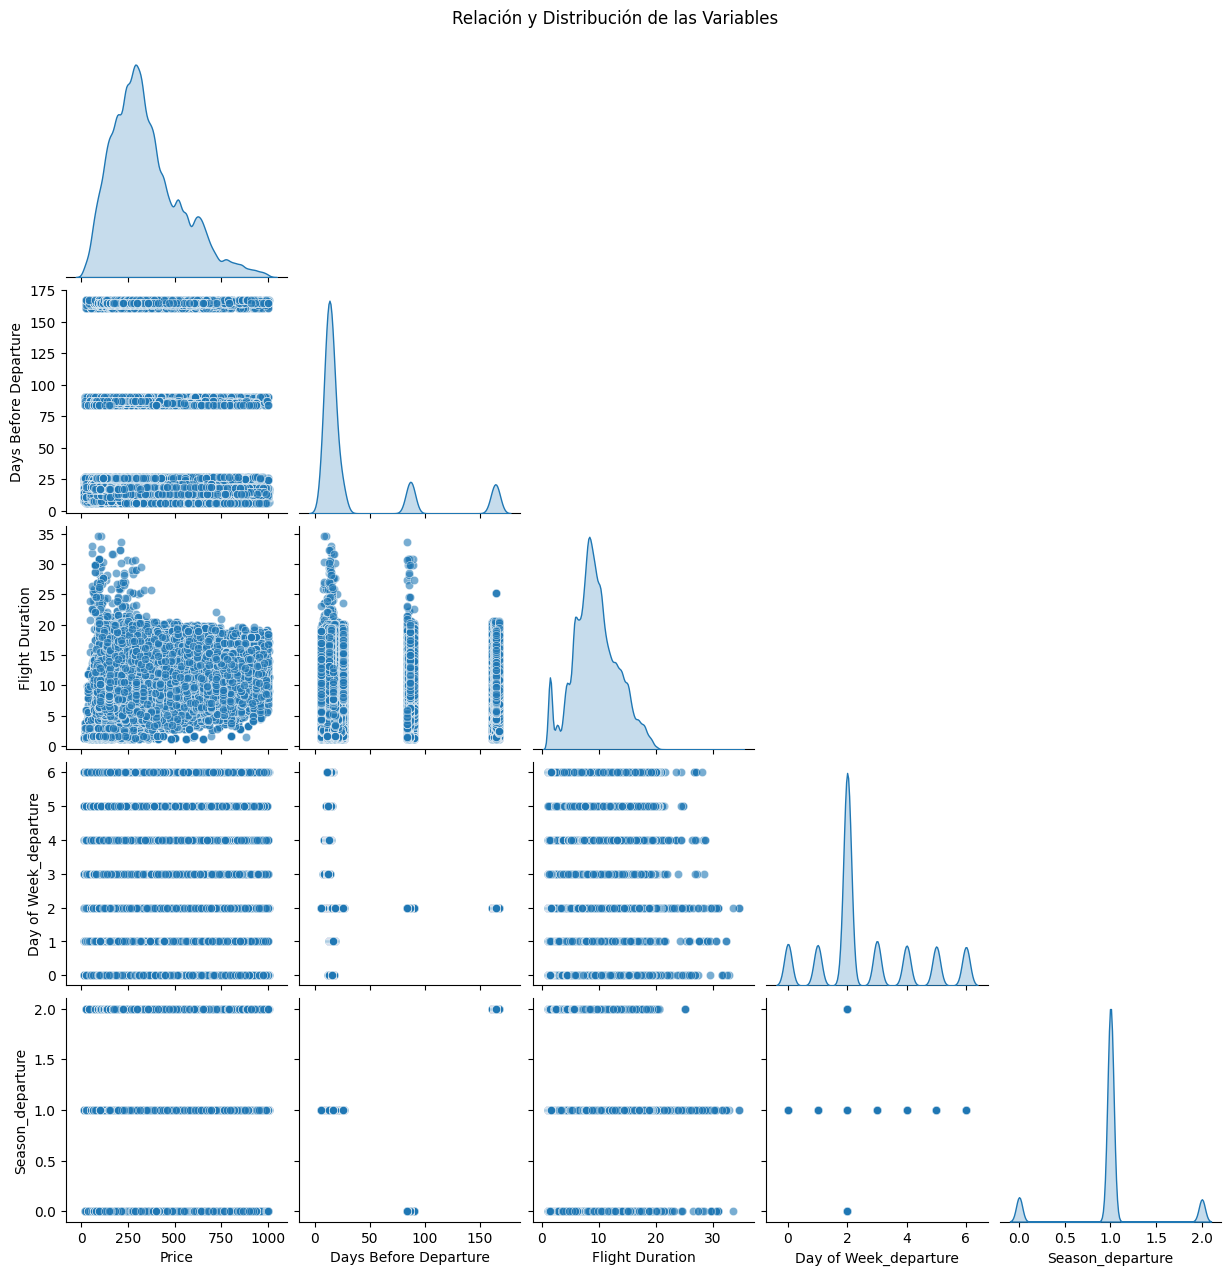

In [ ]:
# Seleccionar un subconjunto de variables para visualizar (variables numéricas y categóricas codificadas)
selected_columns = ['Price', 'Days Before Departure', 'Flight Duration', 'Number Of Stops']
categorical_columns = ['Day of Week_departure', 'Season_departure']

# Combinar variables numéricas y categóricas codificadas
df_subset = df[selected_columns + categorical_columns]

# Convertir variables categóricas a numéricas para facilitar el análisis
for col in categorical_columns:
    df_subset[col] = df_subset[col].astype('category').cat.codes

# Crear el pairplot
sns.pairplot(df_subset, diag_kind='kde', kind='scatter', corner=True, plot_kws={'alpha': 0.6})
plt.suptitle("Relación y Distribución de las Variables", y=1.02)
plt.show()


1. **Distribución de las variables individuales**:
   - **`Price`**: Tiene una distribución sesgada hacia la derecha, lo que sugiere que la mayoría de los precios están en rangos más bajos, pero hay algunos valores muy altos.
   - **`Days Before Departure`**: Presenta picos claros, posiblemente debido a valores discretos específicos como 30, 60 o 90 días antes de la salida.
   - **`Flight Duration`**: Parece tener una distribución unimodal concentrada alrededor de 9-10 horas.
   - **`Day of Week_departure`** y **`Season_departure`**: Estas variables están codificadas y parecen mostrar distribuciones discretas.

2. **Relaciones entre las variables**:
   - **`Price` y `Days Before Departure`**:
     - Hay una relación negativa: precios más altos están asociados con reservas hechas más cerca de la fecha de salida.
   - **`Price` y `Flight Duration`**:
     - Parece no haber una relación clara entre el precio y la duración del vuelo.
   - **`Price` y `Day of Week_departure`**:
     - Los precios no parecen variar mucho según el día de la semana.
   - **`Price` y `Season_departure`**:
     - Aunque hay una ligera variación entre estaciones, la relación no es pronunciada.

3. **Relaciones notables**:
   - **`Days Before Departure`** y otras variables:
     - Muestra patrones discretos, especialmente con las estaciones y días de la semana, lo que indica que hay comportamientos específicos según el tiempo de anticipación en la reserva.


### 1: MODELO DE REGRESIÓN LINEAL

`Price` es la variable objetivo.

**CONSTRUCCIÓN DEL MODELO**

In [ ]:
df2.columns

Index(['Departure Airport', 'Arrival Airport', 'Number Of Stops', 'Price',
       'Days Before Departure', 'Day of Week_departure', 'Season_departure',
       'Flight Duration', 'Cabin Group', 'Airline'],
      dtype='object')

In [ ]:
# Definir variables predictoras y objetivo
X = df2.drop(columns=['Price'])
y = df2['Price']

# Identificar variables categóricas y numéricas
categorical_features = ['Departure Airport', 'Arrival Airport', 'Day of Week_departure', 'Season_departure', 'Airline', 'Cabin Group']
numerical_features = ['Number Of Stops', 'Days Before Departure', 'Flight Duration']

# Preprocesamiento: One-Hot Encoding y Normalización
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Crear pipeline con Regresión Lineal
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


In [ ]:
df_results = pd.DataFrame({
    "Métrica": ["Error Absoluto Medio (MAE)", "Raíz del Error Cuadrático Medio (RMSE)", "Coeficiente de Determinación (R²)"],
    "Valor": [f"{mae:.4f}", f"{rmse:.4f}", f"{r2:.4f}"]
})

print("Resultados del modelo: REGRESIÓN LINEAL ")
print("")
df_results


Resultados del modelo: REGRESIÓN LINEAL 



,Métrica,Valor
0,Error Absoluto Medio (MAE),85.4276
1,Raíz del Error Cuadrático Medio (RMSE),111.5188
2,Coeficiente de Determinación (R²),0.6355


**Error Absoluto Medio (MAE)** = 85.43

En promedio, el modelo se equivoca en $85 en la predicción del precio.


**Raíz del Error Cuadrático Medio (RMSE)** = 111.52

Confirma que el error sigue bajo.


**Coeficiente de Determinación (R²)** = 0.6355

Indica que el modelo explica el 63.55% de la variabilidad del precio.


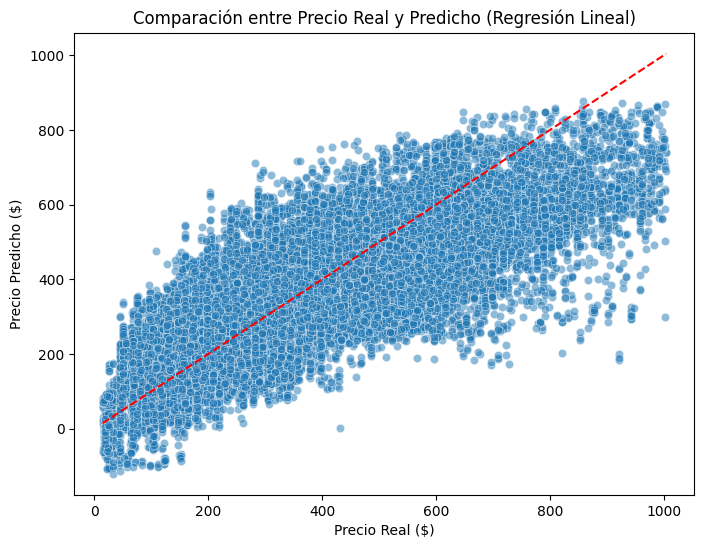

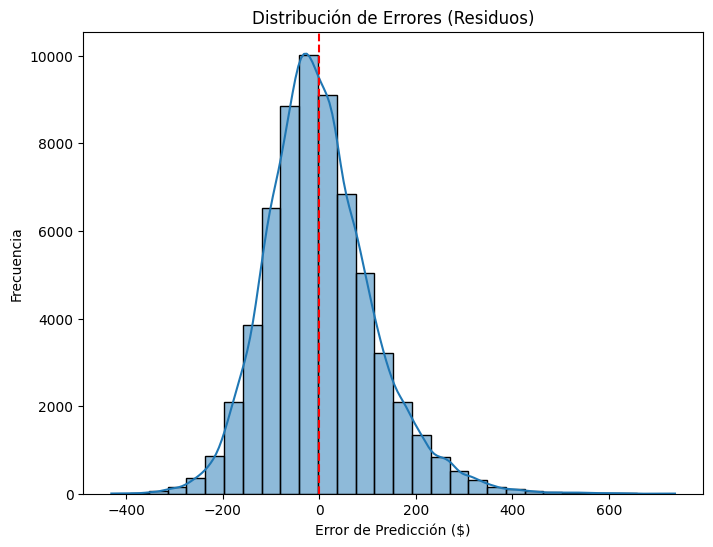

In [ ]:
# Visualización 1: Comparación entre precios reales y predichos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Línea perfecta
plt.xlabel("Precio Real ($)")
plt.ylabel("Precio Predicho ($)")
plt.title("Comparación entre Precio Real y Predicho (Regresión Lineal)")
plt.show()

# Visualización 2: Distribución de errores (residuos)
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')  # Línea en 0 para referencia
plt.xlabel("Error de Predicción ($)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores (Residuos)")
plt.show()

**1. Distribución de Errores (Residuos)**
  - Los errores (residuos) están distribuidos de manera aproximadamente simétrica alrededor de **0**, lo que es una buena señal de que el modelo no tiene sesgo sistemático.
  - Sin embargo, parece haber una leve cola hacia la derecha, lo que indica que hay algunas predicciones significativamente subestimadas.
  - La forma de la distribución es **casi normal**, lo que sugiere que las suposiciones de regresión lineal están siendo cumplidas razonablemente bien.

- **Interpretación**:
  - El modelo lineal está funcionando bien en capturar la relación entre las variables predictoras y el precio.
  - Los errores grandes (positivos o negativos) podrían ser casos especiales, como vuelos con precios extremos debido a eventos o circunstancias específicas.

**2. Comparación entre Precio Real y Predicho**
  - Los puntos están distribuidos alrededor de la línea roja (diagonal), lo que indica que las predicciones del modelo son razonablemente precisas para la mayoría de los datos.
  - Sin embargo, se observa una mayor dispersión en los valores más altos de precios reales, lo que indica que el modelo tiene mayor dificultad para predecir precios altos con precisión.
  - Hay un agrupamiento visible en precios bajos, lo cual puede reflejar una mayor cantidad de vuelos económicos.

- **Interpretación**:
  - El modelo capta bien la relación lineal en el rango intermedio de precios, pero tiene dificultades para capturar la complejidad de los vuelos con precios muy altos o muy bajos.
  - Esto podría indicar que los precios extremos están influenciados por factores adicionales que el modelo no está considerando (ej. eventos especiales, promociones).

### 2: **MODELO POLINOMIAL**

En la imagen del **pairplot**, se pueden observar que la única relación que muestra un posible comportamiento no lineal es **`Price` vs `Days Before Departure`**.

Estas variables tienen una relación negativa evidente: los precios tienden a ser más altos cuando los vuelos se reservan con menos días de antelación. Parece que esta relación podría no ser perfectamente lineal. Existe una disminución pronunciada al principio (reservas cercanas a la fecha de salida) y luego una estabilización para reservas más lejanas. Esto sugiere que un modelo polinomial de grado 2 podría ser útil aquí.

Es por eso que se empleará un modelo polinomial de grado 2 para capturar la curvatura en esta relación.



In [ ]:
# Crear un modelo de regresión polinomial de grado 2
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# Pipeline con preprocesador, transformación polinómica y regresión lineal
poly_model = Pipeline([
    ('preprocessor', preprocessor),
    ('poly_features', poly_features),
    ('regressor', LinearRegression())
])

# Entrenar modelo polinomial
poly_model.fit(X_train, y_train)

# Predicciones
y_pred_poly = poly_model.predict(X_test)

# Evaluación del modelo polinomial
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

# Resultados del modelo polinomial
mae_poly, rmse_poly, r2_poly


(65.23475364949886, 87.50181936748417, 0.7755932536800655)

In [ ]:
df_results = pd.DataFrame({
    "Métrica": ["Error Absoluto Medio (MAE)", "Raíz del Error Cuadrático Medio (RMSE)", "Coeficiente de Determinación (R²)"],
    "Valor": [f"{mae_poly:.4f}", f"{rmse_poly:.4f}", f"{r2_poly:.4f}"]
})

print("Resultados del modelo: REGRESIÓN POLINOMIAL ")
print("")
df_results

Resultados del modelo: REGRESIÓN POLINOMIAL 



,Métrica,Valor
0,Error Absoluto Medio (MAE),65.2348
1,Raíz del Error Cuadrático Medio (RMSE),87.5018
2,Coeficiente de Determinación (R²),0.7756


1. **Error Absoluto Medio (MAE) = 65.23**  
   - En promedio, el modelo se equivoca en **$65**, mejor que el modelo lineal (**$85.43**).  
   - Indica una mejora significativa en la precisión.

2. **Raíz del Error Cuadrático Medio (RMSE) = 87.50**  
   - Más bajo que el modelo lineal (**$111.52**), lo que indica que también se han reducido los errores grandes (outliers).

3. **Coeficiente de Determinación (R²) = 0.7756**  
   - Explica el **77.56% de la variabilidad** del precio.  
   - Mucho mejor que el modelo lineal (**63.55%**), lo que sugiere que la relación entre variables y precio es **no lineal**.


**Conclusión** :

**El modelo polinomial es mejor que el lineal**, ya que tiene:
- **Menor error absoluto (MAE y RMSE)**.
- **Mayor capacidad explicativa (R² más alto)**.

Esto indica que la relación entre **las variables y el precio de los vuelos es más compleja que una simple línea recta** y que agregar términos polinomiales ayuda a capturar mejor las tendencias.


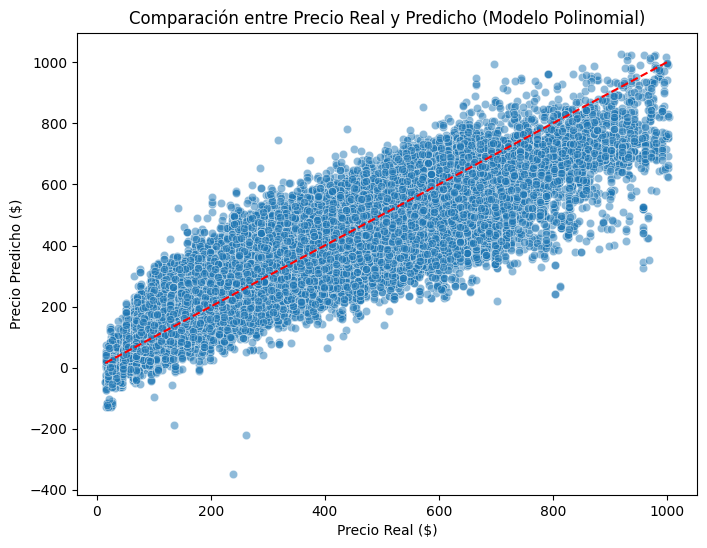

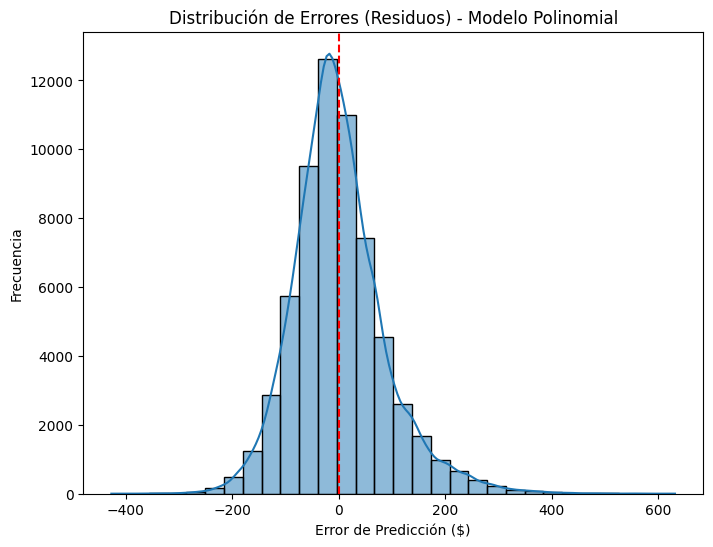

In [ ]:
# Comparación entre precios reales y predichos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_poly, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Línea perfecta
plt.xlabel("Precio Real ($)")
plt.ylabel("Precio Predicho ($)")
plt.title("Comparación entre Precio Real y Predicho (Modelo Polinomial)")
plt.show()

# Distribución de errores (residuos)
residuals = y_test - y_pred_poly
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')  # Línea en 0 para referencia
plt.xlabel("Error de Predicción ($)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores (Residuos) - Modelo Polinomial")
plt.show()


**1. Distribución de Errores (Residuos)**
  - La distribución de los errores es **simétrica** y está centrada alrededor de 0, lo que indica que el modelo no tiene un sesgo sistemático.
  - Hay una ligera cola hacia valores positivos (errores de subestimación), lo que puede significar que el modelo tiene dificultades para predecir precios altos.
  - La forma de la distribución se asemeja a una distribución normal, lo que respalda la validez de las suposiciones del modelo.

- **CONCLUSIÓN**:
  - Esto indica que el modelo polinomial está funcionando bien, aunque podría haber margen de mejora en los extremos (precios muy altos o bajos).


**2. Comparación entre Precio Real y Predicho**
  - La mayoría de los puntos se agrupan cerca de la línea roja (predicción perfecta), lo que muestra que el modelo tiene una buena precisión general.
  - A medida que los precios reales aumentan, hay mayor dispersión en las predicciones, lo que indica que el modelo tiene más dificultad para predecir correctamente los precios altos.


- **Conclusión**:
  - El modelo polinomial logra capturar la relación entre las variables predictoras y el precio razonablemente bien, aunque con errores más grandes en los extremos.


**Comparación entre el Modelo Lineal y el Modelo Polinomial**

**1. Distribución de Errores (Residuos)**

**Modelo Lineal**:
- La distribución es simétrica y se aproxima a una distribución normal.
- Sin embargo, presenta colas más pronunciadas, especialmente en los errores positivos, indicando que hay más errores al predecir precios altos.
- Tiene más dispersión en general, lo que sugiere menor precisión.

**Modelo Polinomial**:
- La distribución sigue siendo simétrica y normal, pero las colas son menos pronunciadas que en el modelo lineal.
- Esto indica que el modelo polinomial mejora las predicciones en los extremos, especialmente para precios altos.

**Conclusión**:
El modelo polinomial gestiona mejor los errores y tiene una distribución más concentrada, lo que indica una mejora en precisión.

---
**2. Comparación entre Precio Real y Predicho**

**Modelo Lineal**:
- Los puntos están agrupados cerca de la línea roja en el rango de precios medios, pero hay mayor dispersión en precios altos y bajos.
- Tiene mayor dificultad para capturar patrones en los extremos, lo que genera errores más grandes.

**Modelo Polinomial**:
- Los puntos están mejor alineados con la línea roja en todos los rangos de precios.
- Aunque hay algo de dispersión en precios altos, es menor comparado con el modelo lineal.

**Conclusión**:
El modelo polinomial captura patrones más complejos y mejora las predicciones, especialmente en precios extremos.


In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Cross Validation para modelo lineal
linear_scores = cross_val_score(model, X, np.log1p(y), cv=5, scoring='neg_mean_squared_error')
linear_rmse = np.sqrt(-linear_scores.mean())

# Cross Validation para modelo polinomial
poly_scores = cross_val_score(poly_model, X, np.log1p(y), cv=5, scoring='neg_mean_squared_error')
poly_rmse = np.sqrt(-poly_scores.mean())

print(f"Modelo Lineal - RMSE (Cross Validation): {linear_rmse}")
print(f"Modelo Polinomial - RMSE (Cross Validation): {poly_rmse}")


Modelo Lineal - RMSE (Cross Validation): 0.35307973508371604
Modelo Polinomial - RMSE (Cross Validation): 0.2652476667469316


**Análisis de los Resultados de Cross Validation**

**1. Modelo Lineal: RMSE = 0.3531**
- El modelo lineal tiene un error promedio más alto en comparación con el modelo polinomial.
- Esto confirma que el modelo lineal no es capaz de capturar completamente las relaciones complejas entre las variables predictoras y el precio.

**2. Modelo Polinomial: RMSE = 0.2652**
- El modelo polinomial tiene un error más bajo, lo que indica que está capturando mejor las relaciones no lineales en los datos.
- Esto respalda los resultados previos: el modelo polinomial es más adecuado para este problema.

---

**CONCLUSIÓN**
1. **Modelo Lineal**:
   - Es una buena opción inicial, pero sus limitaciones son evidentes en este caso debido a las relaciones no lineales en los datos.

2. **Modelo Polinomial**:
   - Al incluir términos polinómicos (grado 2), este modelo es más flexible y logra un mejor ajuste, reflejado en su menor RMSE.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar instalación de scikit-learn
!pip install --upgrade scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Asegurar que mean_squared_error no ha sido sobrescrito
del mean_squared_error
from sklearn.metrics import mean_squared_error

# Cargar el dataset limpio
df = df2.copy()

# Separar variables numéricas y categóricas
num_features = ['Days Before Departure', 'Flight Duration', 'Number Of Stops']
cat_features = ['Departure Airport', 'Arrival Airport', 'Airline', 'Cabin Group']

# Definir la variable objetivo
target = 'Price'

# División de datos en train y test
X = df[num_features + cat_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesamiento: Escalar numéricas y One-Hot Encoding en categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

# Modelos a evaluar
models = {
    'Regresión Lineal': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Evaluación de modelos
results = []
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Calcular RMSE manualmente sin usar `squared=False`
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({'Modelo': name, 'RMSE': rmse, 'MAE': mae, 'R²': r2})

# Convertir a DataFrame para mostrar resultados
results_df = pd.DataFrame(results)

# Mostrar tabla de comparación de modelos

results_df